In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [3]:
"""
To see how to train, ref the below links:
https://github.com/pytorch/examples/tree/master/mnist
and
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

"""
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        #return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(),])),
                   batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [4]:
import torch
import operator as op
import functools as ft


'''reduce_* helper functions reduce tensors on all dimensions but the first.
They are intended to be used on batched tensors where dim 0 is the batch dim.
'''


def reduce_sum(x, keepdim=True):
    # silly PyTorch, when will you get proper reducing sums/means?
    for a in reversed(range(1, x.dim())):
        x = x.sum(a, keepdim=keepdim)
    return x


def reduce_mean(x, keepdim=True):
    numel = ft.reduce(op.mul, x.size()[1:])
    x = reduce_sum(x, keepdim=keepdim)
    return x / numel


def reduce_min(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.min(a, keepdim=keepdim)[0]
    return x


def reduce_max(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.max(a, keepdim=keepdim)[0]
    return x


def torch_arctanh(x, eps=1e-6):
    x *= (1. - eps)
    return (torch.log((1 + x) / (1 - x))) * 0.5


def l2r_dist(x, y, keepdim=True, eps=1e-8):
    d = (x - y)**2
    d = reduce_sum(d, keepdim=keepdim)
    d += eps  # to prevent infinite gradient at 0
    return d.sqrt()


def l2_dist(x, y, keepdim=True):
    d = (x - y)**2
    return reduce_sum(d, keepdim=keepdim)


def l1_dist(x, y, keepdim=True):
    d = torch.abs(x - y)
    return reduce_sum(d, keepdim=keepdim)


def l2_norm(x, keepdim=True):
    norm = reduce_sum(x*x, keepdim=keepdim)
    return norm.sqrt()


def l1_norm(x, keepdim=True):
    return reduce_sum(x.abs(), keepdim=keepdim)


def rescale(x, x_min=-1., x_max=1.):
    return x * (x_max - x_min) + x_min


def tanh_rescale(x, x_min=-1., x_max=1.):
    return (torch.tanh(x) + 1) * 0.5 * (x_max - x_min) + x_min

In [5]:
"""PyTorch Carlini and Wagner L2 attack algorithm.

Based on paper by Carlini & Wagner, https://arxiv.org/abs/1608.04644 and a reference implementation at
https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py
"""
import os
import sys
import torch
import numpy as np
from torch import optim
from torch import autograd
#from .helpers import *


class AttackCarliniWagnerL2:

    def __init__(self, targeted=True, search_steps=None, max_steps=None, cuda=True, debug=False):
        self.debug = debug
        self.targeted = targeted
        #self.num_classes = 1000
        self.num_classes = 10
        self.confidence = 0  # FIXME need to find a good value for this, 0 value used in paper not doing much...
        self.initial_const = 0.1  # bumped up from default of .01 in reference code
        self.binary_search_steps = search_steps or 5
        self.repeat = self.binary_search_steps >= 10
        self.max_steps = max_steps or 1000
        self.abort_early = True
        self.clip_min = -1.
        self.clip_max = 1.
        self.cuda = cuda
        self.clamp_fn = 'tanh'  # set to something else perform a simple clamp instead of tanh
        self.init_rand = False  # an experiment, does a random starting point help?

    def _compare(self, output, target):
        if not isinstance(output, (float, int, np.int64)):
            output = np.copy(output)
            if self.targeted:
                output[target] -= self.confidence
            else:
                output[target] += self.confidence
            output = np.argmax(output)
        if self.targeted:
            return output == target
        else:
            return output != target

    def _loss(self, output, target, dist, scale_const):
        # compute the probability of the label class versus the maximum other
        
        # for the targeted attack, real will contain the current logit values for the targeted class
        # This basically tell us what is the current probability of the image being classified as the target class
        # multiplying by one hot encoded target ensures that other (index != target) logit values become 0
        # sum(1) simply gives us the logit value of the target class
        real = (target * output).sum(1)
        
        # indices other than target class will have their logit values, target index will have -10000
        # takes the maximum value when we suppress the logit of the targeted class
        # this will give the logit of the most likely other class
        # in the first run, this would most likely be the prob of the true class
        other = ((1. - target) * output - target * 10000.).max(1)[0]
        
        print('output: ', output)
        print('real: ', real)
        print('other: ', other)
        
        print('dist shape: ', dist.shape)
        print('dist: ', dist)
        
        if self.targeted:
            # if targeted, optimize for making the other class most likely
            loss1 = torch.clamp(other - real + self.confidence, min=0.)  # equiv to max(..., 0.)
        else:
            # if non-targeted, optimize for making this class least likely.
            loss1 = torch.clamp(real - other + self.confidence, min=0.)  # equiv to max(..., 0.)
        
        loss1 = torch.sum(scale_const * loss1)
        loss2 = dist.sum()
        
        print('loss2 which is dist.sum: ', loss2)

        loss = loss1 + loss2
        print('loss: ', loss)
        
        return loss

    def _optimize(self, optimizer, model, input_var, modifier_var, target_var, scale_const_var, input_orig=None):
        # apply modifier and clamp resulting image to keep bounded from clip_min to clip_max
        if self.clamp_fn == 'tanh':
            input_adv = tanh_rescale(modifier_var + input_var, self.clip_min, self.clip_max)
        else:
            input_adv = torch.clamp(modifier_var + input_var, self.clip_min, self.clip_max)

        output = model(input_adv)

        # distance to the original input data
        if input_orig is None:
            dist = l2_dist(input_adv, input_var, keepdim=False)
        else:
            dist = l2_dist(input_adv, input_orig, keepdim=False)
            
            

        loss = self._loss(output, target_var, dist, scale_const_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss_np = loss.data[0] #throws error
        loss_np = loss.data
        dist_np = dist.data.cpu().numpy()
        output_np = output.data.cpu().numpy()
        input_adv_np = input_adv.data.permute(0, 2, 3, 1).cpu().numpy()  # back to BHWC for numpy consumption
        return loss_np, dist_np, output_np, input_adv_np

    def run(self, model, input, target, batch_idx=0):
        batch_size = input.size(0)
        print('batch size: ', batch_size)
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        scale_const = np.ones(batch_size) * self.initial_const
        upper_bound = np.ones(batch_size) * 1e10

        # python/numpy placeholders for the overall best l2, label score, and adversarial image
        o_best_l2 = [1e10] * batch_size
        o_best_score = [-1] * batch_size
        o_best_attack = input.permute(0, 2, 3, 1).cpu().numpy()

        # setup input (image) variable, clamp/scale as necessary
        if self.clamp_fn == 'tanh':
            # convert to tanh-space, input already int -1 to 1 range, does it make sense to do
            # this as per the reference implementation or can we skip the arctanh?
            input_var = autograd.Variable(torch_arctanh(input), requires_grad=False)
            input_orig = tanh_rescale(input_var, self.clip_min, self.clip_max)
        else:
            input_var = autograd.Variable(input, requires_grad=False)
            input_orig = None

        # setup the target variable, we need it to be in one-hot form for the loss function
        target_onehot = torch.zeros(target.size() + (self.num_classes,))
        if self.cuda:
            target_onehot = target_onehot.cuda()
        target_onehot.scatter_(1, target.unsqueeze(1), 1.)
        
        #target_onehot will have a 1 at the index of the targeted class (in the case of targeted attack)
        print('target_onehot: ', target_onehot)
        
        target_var = autograd.Variable(target_onehot, requires_grad=False)

        # setup the modifier variable, this is the variable we are optimizing over
        modifier = torch.zeros(input_var.size()).float()
        if self.init_rand:
            # Experiment with a non-zero starting point...
            modifier = torch.normal(means=modifier, std=0.001)
        if self.cuda:
            modifier = modifier.cuda()
        modifier_var = autograd.Variable(modifier, requires_grad=True)

        optimizer = optim.Adam([modifier_var], lr=0.0005)

        for search_step in range(self.binary_search_steps):
            print('Batch: {0:>3}, search step: {1}'.format(batch_idx, search_step))
            if self.debug:
                print('Const:')
                for i, x in enumerate(scale_const):
                    print(i, x)
            best_l2 = [1e10] * batch_size
            best_score = [-1] * batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat and search_step == self.binary_search_steps - 1:
                scale_const = upper_bound

            scale_const_tensor = torch.from_numpy(scale_const).float()
            if self.cuda:
                scale_const_tensor = scale_const_tensor.cuda()
            scale_const_var = autograd.Variable(scale_const_tensor, requires_grad=False)

            prev_loss = 1e6
            for step in range(self.max_steps):
                # perform the attack
                loss, dist, output, adv_img = self._optimize(
                    optimizer,
                    model,
                    input_var,
                    modifier_var,
                    target_var,
                    scale_const_var,
                    input_orig)

                if step % 100 == 0 or step == self.max_steps - 1:
                    print('Step: {0:>4}, loss: {1:6.4f}, dist: {2:8.5f}, modifier mean: {3:.5e}'.format(
                        step, loss, dist.mean(), modifier_var.data.mean()))

                if self.abort_early and step % (self.max_steps // 10) == 0:
                    if loss > prev_loss * .9999:
                        print('Aborting early...')
                        break
                    prev_loss = loss

                # update best result found
                for i in range(batch_size):
                    target_label = target[i]
                    output_logits = output[i]
                    output_label = np.argmax(output_logits)
                    di = dist[i]
                    if self.debug:
                        if step % 100 == 0:
                            print('{0:>2} dist: {1:.5f}, output: {2:>3}, {3:5.3}, target {4:>3}'.format(
                                i, di, output_label, output_logits[output_label], target_label))
                    if di < best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best step,  prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, best_l2[i], di))
                        best_l2[i] = di
                        best_score[i] = output_label
                    if di < o_best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best total, prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, o_best_l2[i], di))
                        o_best_l2[i] = di
                        o_best_score[i] = output_label
                        o_best_attack[i] = adv_img[i]

                sys.stdout.flush()
                # end inner step loop

            # adjust the constants
            batch_failure = 0
            batch_success = 0
            for i in range(batch_size):
                if self._compare(best_score[i], target[i]) and best_score[i] != -1:
                    # successful, do binary search and divide const by two
                    upper_bound[i] = min(upper_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    if self.debug:
                        print('{0:>2} successful attack, lowering const to {1:.3f}'.format(
                            i, scale_const[i]))
                else:
                    # failure, multiply by 10 if no solution found
                    # or do binary search with the known upper bound
                    lower_bound[i] = max(lower_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        scale_const[i] *= 10
                    if self.debug:
                        print('{0:>2} failed attack, raising const to {1:.3f}'.format(
                            i, scale_const[i]))
                if self._compare(o_best_score[i], target[i]) and o_best_score[i] != -1:
                    batch_success += 1
                else:
                    batch_failure += 1

            print('Num failures: {0:2d}, num successes: {1:2d}\n'.format(batch_failure, batch_success))
            sys.stdout.flush()
            # end outer search loop

        return o_best_attack


In [6]:
TARGETED = True
MAX_STEPS = 1000
SEARCH_STEPS = 6
NO_CUDA = False
DEBUG = False

attack = AttackCarliniWagnerL2(
        targeted=TARGETED,
        max_steps=MAX_STEPS,
        search_steps=SEARCH_STEPS,
        cuda=not NO_CUDA,
        debug=DEBUG)

In [ ]:
#for batch_idx, (input, target) in enumerate(loader):
    
#     input = input.cuda()
#     target = target.cuda()

#     input_adv = attack.run(model, input, target, batch_idx)

#     start_index = args.batch_size * batch_idx
#     indices = list(range(start_index, start_index + input.size(0)))
#     for filename, o in zip(dataset.filenames(indices, basename=True), input_adv):
#         output_file = os.path.join(args.output_dir, filename)
#         imsave(output_file, (o + 1.0) * 0.5, format='png')

In [7]:
loader = test_loader

iterations = 0
thresh_on_iterations = 1

success_record = []

for batch_idx, (input_tensor, input_label) in enumerate(loader):
    print('\n\n-------iteration: {}----------'.format(iterations))
    
    # clean image
    input_tensor = input_tensor.cuda()
    
    # original label for the clean image
    input_label = input_label.cuda()
    
    pred_input = model(input_tensor)
    pred_prob_input = F.softmax(pred_input, dim=1)
    print('prediction of adversarial sample: {} with probability: {}'
          .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))
    
    # if the attack is targeted, we will target the next class modulo number of classes
    if TARGETED == True:
        target = (input_label+1)%10
    # else the target is kept as the original label as per attack design
    else:
        target = input_label
    
    # result obtained is a numpy array
    adversarial_img = attack.run(model, input_tensor, target, batch_idx)
    
    # reshape
    adversarial_img = np.transpose(adversarial_img, (0,3,1,2))
    
    # conver to torch tensor
    adversarial_tensor = torch.from_numpy(adversarial_img).cuda()
    
    # obtain the prediction by the model
    pred_adv = model(adversarial_tensor)
    pred_prob_adv = F.softmax(pred_adv, dim=1)
    print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))

    
    clean_label = input_label.item()
    #pred_adv_label = torch.max(pred_adv, 1)[1].item()
    pred_adv_label = torch.argmax(pred_prob_adv)
    
    print('Original label of the clean image is: {} and predicted label of the adversarial image is {}'\
          .format(clean_label,pred_adv_label))
    
    result = 0
    if TARGETED:
        if pred_adv_label == target.item():
            result = 1
    else:
        if pred_adv_label != clean_label:
            result = 1
    
    success_record.append(result)
    
    iterations += 1
    if iterations == thresh_on_iterations:
        break



-------iteration: 0----------
batch size:  1
target_onehot:  tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
Batch:   0, search step: 0
output:  tensor([[ 4.1624, -1.5746,  0.3370, -0.7283, -2.9053,  0.6801, -0.8733,  0.6867,
          0.2956, -0.3706]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5746], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1624], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5737, device='cuda:0', grad_fn=<AddBackward0>)
Step:    0, loss: 0.5737, dist:  0.00000, modifier mean: 6.73017e-05
output:  tensor([[ 4.1539, -1.5700,  0.3378, -0.7264, -2.9008,  0.6780, -0.8734,  0.6854,
          0.2941, -0.3711]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5700], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1539

output:  tensor([[ 4.0762, -1.5290,  0.3456, -0.7093, -2.8561,  0.6616, -0.8626,  0.6638,
          0.2918, -0.3763]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5290], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0762], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0062], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0062, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0736, -1.5279,  0.3456, -0.7086, -2.8544,  0.6615, -0.8618,  0.6627,
          0.2920, -0.3763]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5279], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0736], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0065], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0065, device='cuda:0', grad_fn=<SumBackward0>)

loss2 which is dist.sum:  tensor(0.0078, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0579, -1.5223,  0.3442, -0.7036, -2.8454,  0.6632, -0.8570,  0.6556,
          0.2934, -0.3748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5223], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0579], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0078], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0078, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0577, -1.5222,  0.3443, -0.7035, -2.8454,  0.6631, -0.8569,  0.6554,
          0.2935, -0.3748]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5222], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0577], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

other:  tensor([4.0583], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0076, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0584, -1.5201,  0.3478, -0.7031, -2.8481,  0.6601, -0.8590,  0.6562,
          0.2924, -0.3768]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5201], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0584], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0076, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0584, -1.5200,  0.3479, -0.7030, -2.8482,  0.6600, -0.8592,  0.6563,
          0.2923, -0.3769]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[ 4.0578, -1.5191,  0.3492, -0.7023, -2.8490,  0.6587, -0.8605,  0.6567,
          0.2917, -0.3772]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5191], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0578], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0077], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0077, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0577, -1.5190,  0.3493, -0.7022, -2.8490,  0.6586, -0.8606,  0.6566,
          0.2917, -0.3772]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5190], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0577], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0077], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0077, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0079], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0079, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0562, -1.5176,  0.3506, -0.7014, -2.8490,  0.6575, -0.8609,  0.6561,
          0.2914, -0.3779]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5176], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0562], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0079], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0079, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0561, -1.5175,  0.3507, -0.7013, -2.8490,  0.6574, -0.8609,  0.6561,
          0.2914, -0.3779]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5175], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0561], device

other:  tensor([4.0553], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0080], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0080, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0552, -1.5165,  0.3516, -0.7010, -2.8490,  0.6565, -0.8611,  0.6558,
          0.2914, -0.3783]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5165], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0552], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0080], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0080, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0552, -1.5165,  0.3517, -0.7010, -2.8490,  0.6565, -0.8611,  0.6558,
          0.2914, -0.3784]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[ 4.0546, -1.5160,  0.3521, -0.7007, -2.8489,  0.6561, -0.8611,  0.6555,
          0.2915, -0.3785]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0546], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0081, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0546, -1.5160,  0.3521, -0.7007, -2.8489,  0.6561, -0.8611,  0.6555,
          0.2915, -0.3785]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0546], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0081, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0082], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0082, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0542, -1.5156,  0.3526, -0.7005, -2.8489,  0.6557, -0.8612,  0.6553,
          0.2916, -0.3787]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5156], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0542], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0082], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0082, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0542, -1.5156,  0.3526, -0.7005, -2.8489,  0.6557, -0.8612,  0.6554,
          0.2916, -0.3787]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5156], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0542], device

dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0540, -1.5153,  0.3529, -0.7004, -2.8490,  0.6554, -0.8613,  0.6553,
          0.2915, -0.3788]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5153], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0540], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0540, -1.5153,  0.3529, -0.7004, -2.8490,  0.6554, -0.8613,  0.6553,
          0.2916, -0.3788]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5153], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0540], device

other:  tensor([4.0539], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0539, -1.5151,  0.3531, -0.7003, -2.8490,  0.6552, -0.8613,  0.6552,
          0.2915, -0.3789]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0539], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0538, -1.5151,  0.3531, -0.7003, -2.8490,  0.6552, -0.8613,  0.6552,
          0.2916, -0.3789]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[ 4.0537, -1.5150,  0.3532, -0.7002, -2.8490,  0.6551, -0.8614,  0.6552,
          0.2916, -0.3789]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5150], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0537], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0537, -1.5150,  0.3532, -0.7002, -2.8490,  0.6551, -0.8614,  0.6552,
          0.2916, -0.3789]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5150], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0537], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0537, -1.5149,  0.3533, -0.7002, -2.8490,  0.6550, -0.8613,  0.6551,
          0.2916, -0.3790]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0537], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0537, -1.5149,  0.3533, -0.7002, -2.8490,  0.6551, -0.8613,  0.6551,
          0.2916, -0.3790]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0537], device

dist:  tensor([0.0103], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0103, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.5613, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0258, -1.5005,  0.3555, -0.6934, -2.8345,  0.6494, -0.8602,  0.6495,
          0.2886, -0.3800]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.5005], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0258], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0137], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0137, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.5400, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 4.0067, -1.4907,  0.3571, -0.6886, -2.8246,  0.6457, -0.8595,  0.6457,
          0.2864, -0.3807]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.4907], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0067], device

output:  tensor([[ 3.6812, -1.3320,  0.3812, -0.5991, -2.6531,  0.5870, -0.8416,  0.5717,
          0.2549, -0.3906]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3320], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6812], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1897], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1897, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.2029, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.6595, -1.3224,  0.3821, -0.5927, -2.6412,  0.5848, -0.8390,  0.5655,
          0.2536, -0.3909]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.3224], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6595], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2042], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2042, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.3811], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3811, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0340, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.4209, -1.2154,  0.3967, -0.5248, -2.5028,  0.5583, -0.7996,  0.4883,
          0.2497, -0.3988]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2154], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4209], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3906], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3906, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0269, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.4100, -1.2105,  0.3974, -0.5216, -2.4966,  0.5571, -0.7980,  0.4849,
          0.2494, -0.3991]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.2105], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4100], device

other:  tensor([3.2848], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.5088], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.5088, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9423, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.2776, -1.1447,  0.4147, -0.4833, -2.4250,  0.5342, -0.7852,  0.4466,
          0.2446, -0.4085]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.1447], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.2776], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.5156], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.5156, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.9379, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.2706, -1.1409,  0.4158, -0.4814, -2.4212,  0.5328, -0.7844,  0.4446,
          0.2441, -0.4094]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[ 3.1782, -1.1011,  0.4377, -0.4579, -2.3801,  0.5433, -0.7439,  0.4007,
          0.2702, -0.4278]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.1011], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1782], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.6046], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.6046, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.8839, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.1726, -1.0989,  0.4392, -0.4566, -2.3776,  0.5443, -0.7410,  0.3978,
          0.2725, -0.4289]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0989], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1726], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.6097], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.6097, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([0.6724], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.6724, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.8442, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.0951, -1.0697,  0.4556, -0.4338, -2.3453,  0.5601, -0.7022,  0.3556,
          0.3017, -0.4403]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0697], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0951], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.6766], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.6766, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.8415, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.0895, -1.0684,  0.4564, -0.4314, -2.3435,  0.5619, -0.6996,  0.3522,
          0.3040, -0.4407]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0684], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0895], device

output:  tensor([[ 3.0155, -1.0453,  0.4682, -0.4025, -2.3159,  0.5780, -0.6681,  0.3111,
          0.3302, -0.4482]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0453], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.7409], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.7409, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.8017, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 3.0099, -1.0437,  0.4690, -0.4003, -2.3140,  0.5796, -0.6656,  0.3080,
          0.3323, -0.4486]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0437], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0099], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.7453], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.7453, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.9175, -1.0301,  0.4646, -0.3570, -2.2857,  0.6235, -0.6241,  0.2533,
          0.3730, -0.4415]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0301], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9175], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.8100], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.8100, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.7576, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.9091, -1.0298,  0.4616, -0.3519, -2.2841,  0.6294, -0.6205,  0.2477,
          0.3765, -0.4397]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0298], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9091], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.8152], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.8152, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.7840, -1.0245,  0.4144, -0.2714, -2.2657,  0.7202, -0.5712,  0.1670,
          0.4183, -0.4158]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0245], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.7840], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.8971], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.8971, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.7056, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.7776, -1.0237,  0.4125, -0.2673, -2.2646,  0.7242, -0.5687,  0.1627,
          0.4201, -0.4152]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0237], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.7776], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.9016], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.9016, device='cuda:0', grad_fn=<SumBackward0>)

loss2 which is dist.sum:  tensor(0.9607, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6739, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.6974, -1.0102,  0.3935, -0.2161, -2.2500,  0.7672, -0.5412,  0.1125,
          0.4374, -0.4114]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0102], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.6974], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.9648], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.9648, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6724, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.6929, -1.0091,  0.3928, -0.2135, -2.2490,  0.7690, -0.5401,  0.1101,
          0.4381, -0.4113]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-1.0091], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.6929], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

output:  tensor([[ 2.6418, -0.9952,  0.3863, -0.1824, -2.2380,  0.7863, -0.5298,  0.0837,
          0.4431, -0.4117]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9952], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.6418], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0149], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0149, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6519, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.6391, -0.9946,  0.3860, -0.1808, -2.2373,  0.7873, -0.5291,  0.0822,
          0.4435, -0.4117]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9946], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.6391], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0174, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.6059, -0.9855,  0.3833, -0.1636, -2.2283,  0.7978, -0.5211,  0.0664,
          0.4488, -0.4118]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9855], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.6059], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0474], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0474, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6388, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.6039, -0.9850,  0.3832, -0.1627, -2.2276,  0.7985, -0.5204,  0.0653,
          0.4493, -0.4118]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9850], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.6039], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0491], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0491, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([2.5787], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0709], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0709, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6273, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5772, -0.9771,  0.3825, -0.1511, -2.2190,  0.8053, -0.5141,  0.0543,
          0.4534, -0.4123]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9771], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5772], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0723], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0723, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6267, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5758, -0.9767,  0.3825, -0.1505, -2.2186,  0.8056, -0.5138,  0.0537,
          0.4537, -0.4123]], device='cuda:0', grad_fn=<AddmmBackward>)
re

loss2 which is dist.sum:  tensor(1.0902, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6189, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5565, -0.9705,  0.3828, -0.1421, -2.2124,  0.8098, -0.5090,  0.0453,
          0.4565, -0.4133]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9705], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5565], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.0914], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.0914, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6184, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5553, -0.9700,  0.3829, -0.1415, -2.2120,  0.8098, -0.5088,  0.0449,
          0.4565, -0.4135]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9700], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5553], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

dist:  tensor([1.1077], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1077, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6118, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5393, -0.9634,  0.3840, -0.1344, -2.2068,  0.8114, -0.5056,  0.0383,
          0.4569, -0.4157]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9634], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5393], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1087], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1087, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6114, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5382, -0.9631,  0.3839, -0.1338, -2.2065,  0.8118, -0.5053,  0.0378,
          0.4570, -0.4157]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9631], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5382], device

loss:  tensor(4.6064, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5235, -0.9577,  0.3844, -0.1269, -2.2027,  0.8147, -0.5018,  0.0310,
          0.4593, -0.4169]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9577], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5235], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1248], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1248, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6060, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5226, -0.9574,  0.3843, -0.1265, -2.2025,  0.8149, -0.5017,  0.0307,
          0.4593, -0.4169]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9574], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5226], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1258], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

dist:  tensor([1.1354], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1354, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6015, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5125, -0.9525,  0.3866, -0.1219, -2.2004,  0.8142, -0.5012,  0.0274,
          0.4599, -0.4180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9525], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5125], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1361], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1361, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.6012, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5118, -0.9522,  0.3867, -0.1215, -2.2003,  0.8142, -0.5012,  0.0271,
          0.4600, -0.4180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9522], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5118], device

real:  tensor([-0.9485], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5043], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1443], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1443, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5972, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5042, -0.9482,  0.3885, -0.1178, -2.1996,  0.8134, -0.5017,  0.0252,
          0.4597, -0.4187]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9482], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.5042], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1445], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1445, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5969, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.5041, -0.9478,  0.3889, -0.1178, -2.1996,  0.8130, -0.5019,  0.0252,
       

output:  tensor([[ 2.4979, -0.9445,  0.3902, -0.1146, -2.1992,  0.8130, -0.5018,  0.0232,
          0.4592, -0.4198]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9445], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4979], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1506], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1506, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5930, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4977, -0.9442,  0.3904, -0.1145, -2.1992,  0.8128, -0.5019,  0.0231,
          0.4591, -0.4200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9442], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4977], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1509], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1509, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([2.4926], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1561], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1561, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5897, device='cuda:0', grad_fn=<AddBackward0>)
Step:  300, loss: 4.5897, dist:  1.15614, modifier mean: -7.51165e-03
output:  tensor([[ 2.4920, -0.9407,  0.3925, -0.1114, -2.1988,  0.8118, -0.5021,  0.0212,
          0.4586, -0.4214]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9407], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4920], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1567], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1567, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5895, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4915, -0.9404,  0.3928, -0.1111, -2.1988,  0.8117, -0.5023,  0.0212,
   

loss2 which is dist.sum:  tensor(1.1663, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5860, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4834, -0.9356,  0.3977, -0.1061, -2.1985,  0.8095, -0.5040,  0.0197,
          0.4550, -0.4247]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9356], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4834], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1668], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1668, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5858, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4829, -0.9352,  0.3981, -0.1058, -2.1985,  0.8092, -0.5042,  0.0196,
          0.4547, -0.4250]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9352], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4829], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

real:  tensor([-0.9301], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4764], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1762], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1762, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5826, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4757, -0.9298,  0.4029, -0.1016, -2.1981,  0.8055, -0.5067,  0.0189,
          0.4512, -0.4283]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9298], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4757], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1769], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1769, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5825, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4752, -0.9295,  0.4032, -0.1013, -2.1981,  0.8054, -0.5069,  0.0189,
       

output:  tensor([[ 2.4706, -0.9249,  0.4069, -0.0990, -2.1980,  0.8017, -0.5090,  0.0188,
          0.4483, -0.4312]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9249], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4706], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1842], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1842, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5797, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4704, -0.9247,  0.4071, -0.0989, -2.1980,  0.8014, -0.5092,  0.0188,
          0.4481, -0.4313]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9247], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4704], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1844], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1844, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.4664, -0.9206,  0.4101, -0.0967, -2.1980,  0.7977, -0.5118,  0.0191,
          0.4455, -0.4334]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9206], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4664], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1902], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1902, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5772, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4666, -0.9212,  0.4096, -0.0968, -2.1978,  0.7982, -0.5113,  0.0188,
          0.4462, -0.4328]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9212], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4666], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1893], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1893, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([1.1898], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1898, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5751, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4645, -0.9202,  0.4099, -0.0957, -2.1974,  0.7975, -0.5121,  0.0186,
          0.4458, -0.4326]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9202], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4645], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1904], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1904, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5750, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4645, -0.9206,  0.4095, -0.0958, -2.1971,  0.7979, -0.5118,  0.0184,
          0.4463, -0.4321]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9206], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4645], device

output:  tensor([[ 2.4633, -0.9205,  0.4092, -0.0952, -2.1962,  0.7978, -0.5114,  0.0175,
          0.4475, -0.4313]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9205], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4633], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1892], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1892, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5730, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4629, -0.9205,  0.4091, -0.0950, -2.1960,  0.7980, -0.5111,  0.0172,
          0.4477, -0.4312]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9205], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4629], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1893], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1893, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.4560, -0.9189,  0.4094, -0.0936, -2.1922,  0.7978, -0.5096,  0.0155,
          0.4499, -0.4302]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9189], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4560], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1925], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1925, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5673, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4555, -0.9189,  0.4092, -0.0935, -2.1918,  0.7980, -0.5094,  0.0154,
          0.4502, -0.4299]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9189], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4555], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1926], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1926, device='cuda:0', grad_fn=<SumBackward0>)

other:  tensor([2.4488], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1983], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1983, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5642, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4485, -0.9173,  0.4099, -0.0921, -2.1880,  0.7987, -0.5071,  0.0134,
          0.4520, -0.4297]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9173], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4485], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1982], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1982, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5641, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4483, -0.9174,  0.4098, -0.0921, -2.1878,  0.7988, -0.5072,  0.0136,
          0.4519, -0.4296]], device='cuda:0', grad_fn=<AddmmBackward>)
re

output:  tensor([[ 2.4447, -0.9166,  0.4109, -0.0912, -2.1853,  0.7976, -0.5080,  0.0141,
          0.4508, -0.4292]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9166], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4447], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2008], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2008, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5622, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4446, -0.9168,  0.4107, -0.0911, -2.1852,  0.7978, -0.5079,  0.0141,
          0.4509, -0.4291]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9168], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4446], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2006], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2006, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.4443, -0.9169,  0.4105, -0.0913, -2.1836,  0.7966, -0.5089,  0.0150,
          0.4496, -0.4284]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9169], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4443], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1989], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1989, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5601, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4433, -0.9165,  0.4107, -0.0908, -2.1834,  0.7967, -0.5087,  0.0146,
          0.4496, -0.4285]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9165], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4433], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.1999], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.1999, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.4374, -0.9139,  0.4119, -0.0886, -2.1817,  0.7971, -0.5082,  0.0129,
          0.4511, -0.4283]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4374], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2045], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2045, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5558, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4371, -0.9139,  0.4117, -0.0885, -2.1816,  0.7974, -0.5080,  0.0128,
          0.4513, -0.4281]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4371], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2046], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2046, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.4343, -0.9140,  0.4111, -0.0878, -2.1803,  0.7995, -0.5062,  0.0110,
          0.4545, -0.4266]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4343], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2057], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2057, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5540, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4340, -0.9141,  0.4109, -0.0877, -2.1802,  0.7998, -0.5059,  0.0108,
          0.4547, -0.4265]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4340], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2058], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2058, device='cuda:0', grad_fn=<SumBackward0>)

loss2 which is dist.sum:  tensor(1.2047, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5533, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4335, -0.9151,  0.4097, -0.0878, -2.1794,  0.8018, -0.5041,  0.0096,
          0.4566, -0.4253]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4335], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2047], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2047, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5533, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4333, -0.9149,  0.4099, -0.0877, -2.1795,  0.8017, -0.5040,  0.0095,
          0.4567, -0.4255]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4333], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

loss2 which is dist.sum:  tensor(1.2080, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5526, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4322, -0.9134,  0.4110, -0.0874, -2.1796,  0.8007, -0.5043,  0.0093,
          0.4564, -0.4264]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9134], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4322], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2069], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2069, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5525, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4323, -0.9139,  0.4106, -0.0875, -2.1794,  0.8013, -0.5038,  0.0091,
          0.4569, -0.4260]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4323], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

output:  tensor([[ 2.4311, -0.9129,  0.4117, -0.0867, -2.1798,  0.8007, -0.5042,  0.0090,
          0.4564, -0.4266]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9129], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4311], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2081, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5521, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4314, -0.9130,  0.4117, -0.0869, -2.1798,  0.8006, -0.5042,  0.0090,
          0.4565, -0.4266]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4314], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2076, device='cuda:0', grad_fn=<SumBackward0>)

loss:  tensor(4.5518, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4309, -0.9131,  0.4118, -0.0864, -2.1797,  0.8010, -0.5036,  0.0083,
          0.4571, -0.4265]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4309], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2078], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2078, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5517, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4308, -0.9130,  0.4119, -0.0863, -2.1798,  0.8011, -0.5036,  0.0082,
          0.4571, -0.4267]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4308], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2080], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

loss2 which is dist.sum:  tensor(1.2087, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5516, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4299, -0.9132,  0.4116, -0.0857, -2.1798,  0.8015, -0.5038,  0.0081,
          0.4574, -0.4259]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9132], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4299], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2084], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2084, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5515, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4299, -0.9132,  0.4116, -0.0857, -2.1799,  0.8017, -0.5038,  0.0081,
          0.4574, -0.4259]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9132], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4299], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

dist:  tensor([1.2088], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2088, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5512, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4295, -0.9136,  0.4115, -0.0853, -2.1798,  0.8023, -0.5033,  0.0075,
          0.4583, -0.4255]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9136], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4295], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2082], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2082, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5513, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4295, -0.9137,  0.4115, -0.0854, -2.1799,  0.8024, -0.5033,  0.0075,
          0.4583, -0.4254]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4295], device

other:  tensor([2.4294], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2080], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2080, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5512, device='cuda:0', grad_fn=<AddBackward0>)
Step:  600, loss: 4.5512, dist:  1.20796, modifier mean: -1.60921e-02
output:  tensor([[ 2.4298, -0.9141,  0.4113, -0.0854, -2.1797,  0.8025, -0.5030,  0.0072,
          0.4590, -0.4249]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4298], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2073], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2073, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5512, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4300, -0.9141,  0.4114, -0.0855, -2.1797,  0.8024, -0.5031,  0.0073,
   

loss:  tensor(4.5511, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4289, -0.9135,  0.4118, -0.0848, -2.1799,  0.8023, -0.5033,  0.0071,
          0.4588, -0.4252]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4289], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2085], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2085, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5509, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4292, -0.9138,  0.4116, -0.0850, -2.1798,  0.8025, -0.5032,  0.0071,
          0.4591, -0.4248]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4292], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2080], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

real:  tensor([-0.9140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4287], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2081, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5508, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4289, -0.9144,  0.4112, -0.0847, -2.1797,  0.8035, -0.5026,  0.0066,
          0.4600, -0.4243]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9144], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4289], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2076, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5509, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4291, -0.9145,  0.4112, -0.0848, -2.1797,  0.8034, -0.5027,  0.0067,
       

output:  tensor([[ 2.4287, -0.9136,  0.4121, -0.0845, -2.1799,  0.8025, -0.5030,  0.0066,
          0.4597, -0.4249]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9136], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4287], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2084], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2084, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5507, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4289, -0.9140,  0.4118, -0.0846, -2.1798,  0.8028, -0.5028,  0.0065,
          0.4600, -0.4245]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4289], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2078], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2078, device='cuda:0', grad_fn=<SumBackward0>)

output:  tensor([[ 2.4280, -0.9131,  0.4125, -0.0840, -2.1802,  0.8024, -0.5033,  0.0065,
          0.4595, -0.4250]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4280], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2094], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2094, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5506, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4283, -0.9134,  0.4124, -0.0841, -2.1802,  0.8024, -0.5033,  0.0066,
          0.4596, -0.4248]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9134], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4283], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2089], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2089, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([1.2088], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2088, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5506, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4273, -0.9135,  0.4121, -0.0836, -2.1800,  0.8033, -0.5029,  0.0060,
          0.4602, -0.4244]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4273], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2096], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2096, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5504, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4270, -0.9130,  0.4125, -0.0834, -2.1800,  0.8029, -0.5030,  0.0061,
          0.4598, -0.4248]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4270], device

output:  tensor([[ 2.4281, -0.9146,  0.4114, -0.0838, -2.1799,  0.8040, -0.5023,  0.0057,
          0.4611, -0.4236]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9146], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4281], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2079], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2079, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5506, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4280, -0.9145,  0.4115, -0.0838, -2.1799,  0.8040, -0.5023,  0.0057,
          0.4611, -0.4237]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9145], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4280], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2080], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2080, device='cuda:0', grad_fn=<SumBackward0>)

loss:  tensor(4.5503, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4265, -0.9131,  0.4125, -0.0831, -2.1800,  0.8031, -0.5028,  0.0056,
          0.4602, -0.4246]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4265], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2109], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2109, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5505, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4264, -0.9131,  0.4125, -0.0830, -2.1800,  0.8032, -0.5028,  0.0056,
          0.4602, -0.4246]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4264], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2111], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

loss2 which is dist.sum:  tensor(1.2084, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5505, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4278, -0.9146,  0.4113, -0.0838, -2.1798,  0.8041, -0.5025,  0.0058,
          0.4614, -0.4232]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9146], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4278], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2081, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5505, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4277, -0.9146,  0.4112, -0.0837, -2.1798,  0.8042, -0.5024,  0.0057,
          0.4614, -0.4232]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9146], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4277], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

output:  tensor([[ 2.4274, -0.9140,  0.4122, -0.0834, -2.1800,  0.8035, -0.5026,  0.0055,
          0.4614, -0.4238]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4274], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2090], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2090, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5504, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4276, -0.9139,  0.4124, -0.0835, -2.1801,  0.8031, -0.5028,  0.0058,
          0.4611, -0.4240]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4276], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2089], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2089, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([1.2082], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2082, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5504, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4282, -0.9148,  0.4113, -0.0839, -2.1797,  0.8038, -0.5025,  0.0058,
          0.4617, -0.4229]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9148], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4282], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2075], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2075, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5505, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4284, -0.9149,  0.4113, -0.0840, -2.1798,  0.8038, -0.5026,  0.0059,
          0.4617, -0.4228]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4284], device

real:  tensor([-0.9138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4261], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2103], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2103, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5502, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4258, -0.9132,  0.4124, -0.0825, -2.1801,  0.8037, -0.5027,  0.0052,
          0.4611, -0.4240]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9132], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4258], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2111], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2111, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5501, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4260, -0.9132,  0.4124, -0.0826, -2.1801,  0.8035, -0.5029,  0.0053,
       

output:  tensor([[ 2.4264, -0.9140,  0.4121, -0.0827, -2.1800,  0.8042, -0.5023,  0.0051,
          0.4619, -0.4235]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4264], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2099], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2099, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5502, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4268, -0.9144,  0.4117, -0.0829, -2.1800,  0.8045, -0.5021,  0.0051,
          0.4621, -0.4231]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9144], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4268], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2091, device='cuda:0', grad_fn=<SumBackward0>)

real:  tensor([-0.9136], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4257], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2108], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2108, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5501, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4260, -0.9140,  0.4119, -0.0825, -2.1799,  0.8042, -0.5024,  0.0050,
          0.4618, -0.4232]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4260], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2103], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2103, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5502, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4263, -0.9139,  0.4120, -0.0827, -2.1799,  0.8040, -0.5025,  0.0051,
       

output:  tensor([[ 2.4260, -0.9138,  0.4120, -0.0826, -2.1799,  0.8041, -0.5023,  0.0048,
          0.4622, -0.4233]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4260], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2102], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2102, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5501, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4259, -0.9138,  0.4120, -0.0825, -2.1799,  0.8042, -0.5022,  0.0048,
          0.4622, -0.4234]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4259], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2105], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2105, device='cuda:0', grad_fn=<SumBackward0>)

dist:  tensor([1.2100], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2100, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5501, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4259, -0.9136,  0.4124, -0.0824, -2.1802,  0.8041, -0.5024,  0.0049,
          0.4619, -0.4236]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9136], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4259], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2105], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2105, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4257, -0.9131,  0.4130, -0.0824, -2.1803,  0.8036, -0.5026,  0.0050,
          0.4616, -0.4241]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4257], device

real:  tensor([-0.9130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4253], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2117], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2117, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4253, -0.9130,  0.4128, -0.0822, -2.1801,  0.8036, -0.5025,  0.0049,
          0.4616, -0.4239]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4253], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2117], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2117, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4256, -0.9135,  0.4125, -0.0824, -2.1801,  0.8039, -0.5024,  0.0049,
       

loss:  tensor(4.5500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4254, -0.9134,  0.4123, -0.0822, -2.1800,  0.8039, -0.5027,  0.0050,
          0.4618, -0.4233]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9134], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4254], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2112], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2112, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4257, -0.9137,  0.4121, -0.0824, -2.1800,  0.8040, -0.5026,  0.0050,
          0.4620, -0.4231]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4257], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2106], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

real:  tensor([-0.9140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4255], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2107], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2107, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5501, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4256, -0.9139,  0.4120, -0.0822, -2.1800,  0.8044, -0.5024,  0.0048,
          0.4623, -0.4230]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4256], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2107], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2107, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5502, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4256, -0.9137,  0.4123, -0.0823, -2.1801,  0.8040, -0.5025,  0.0048,
       

loss:  tensor(4.5500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4258, -0.9138,  0.4124, -0.0822, -2.1801,  0.8042, -0.5021,  0.0045,
          0.4625, -0.4234]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4258], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2104], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.2104, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(4.5500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 2.4263, -0.9141,  0.4121, -0.0825, -2.1801,  0.8044, -0.5020,  0.0045,
          0.4627, -0.4232]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.9141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.4263], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.2097], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

output:  tensor([[ 1.8572, -0.7274,  0.4716,  0.1490, -1.9988,  0.8360, -0.4555, -0.1345,
          0.6407, -0.4217]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.7274], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.8572], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.3062], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.3062, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(28.1528, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 1.8061, -0.7107,  0.4809,  0.1702, -1.9842,  0.8356, -0.4557, -0.1430,
          0.6590, -0.4233]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.7107], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.8061], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.4347], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.4347, device='cuda:0', grad_fn=<SumBackward0>

other:  tensor([1.2204], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([4.2994], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.2994, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(21.4998, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 1.1844, -0.4855,  0.6302,  0.4144, -1.8119,  0.8056, -0.4496, -0.2373,
          0.8860, -0.4736]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.4855], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([1.1844], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([4.4319], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.4319, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(21.1308, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 1.1487, -0.4713,  0.6411,  0.4282, -1.8019,  0.8012, -0.4495, -0.2422,
          0.8993, -0.4779]], device='cuda:0', grad_fn=<AddmmBackward>)


output:  tensor([[ 0.8524, -0.3266,  0.6957,  0.5232, -1.6697,  0.7358, -0.4835, -0.2355,
          0.9220, -0.5033]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3266], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.9220], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([5.8332], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(5.8332, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(18.3190, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.8530, -0.3233,  0.6875,  0.5199, -1.6624,  0.7334, -0.4869, -0.2289,
          0.9061, -0.5008]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.3233], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.9061], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([5.8556], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(5.8556, device='cuda:0', grad_fn=<SumBackward0>

loss2 which is dist.sum:  tensor(6.2992, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(16.8153, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.7647, -0.2706,  0.5697,  0.5510, -1.5740,  0.7715, -0.4836, -0.2030,
          0.7660, -0.4617]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2706], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.7715], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([6.3229], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(6.3229, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(16.7435, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.7643, -0.2652,  0.5693,  0.5501, -1.5710,  0.7662, -0.4875, -0.1972,
          0.7574, -0.4629]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.2652], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.7662], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])

loss:  tensor(14.8398, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6560, -0.1050,  0.6630,  0.6517, -1.5383,  0.6508, -0.6015, -0.0707,
          0.6565, -0.5430]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.1050], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6630], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.0491], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.0491, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.7286, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6461, -0.0937,  0.6678,  0.6624, -1.5362,  0.6440, -0.6106, -0.0621,
          0.6498, -0.5487]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0937], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6678], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.1032], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is d

dist:  tensor([7.2123], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.2123, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.2387, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6477, -0.0440,  0.6529,  0.6533, -1.5053,  0.5989, -0.6362, -0.0179,
          0.5841, -0.5693]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0440], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6533], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.2274], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.2274, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.2006, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6464, -0.0412,  0.6528,  0.6523, -1.5031,  0.5970, -0.6357, -0.0172,
          0.5831, -0.5706]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0412], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6528], devi

output:  tensor([[ 0.6354, -0.0165,  0.6337,  0.6332, -1.4721,  0.5858, -0.6176, -0.0186,
          0.5696, -0.5764]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0165], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6354], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.2876], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.2876, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(13.8062, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6314, -0.0126,  0.6368,  0.6337, -1.4699,  0.5830, -0.6172, -0.0183,
          0.5715, -0.5787]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([-0.0126], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6368], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.3046], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.3046, device='cuda:0', grad_fn=<SumBackward0>

real:  tensor([0.0148], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6253], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.4244], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.4244, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(13.5301, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6124,  0.0158,  0.6218,  0.6209, -1.4393,  0.5730, -0.6000, -0.0216,
          0.5627, -0.5861]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0158], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6218], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.4296], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.4296, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(13.4896, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6119,  0.0163,  0.6159,  0.6210, -1.4375,  0.5759, -0.5980, -0.0228,
       

output:  tensor([[ 0.6122,  0.0322,  0.6033,  0.5981, -1.4132,  0.5676, -0.5789, -0.0265,
          0.5489, -0.5907]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0322], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6122], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.5124], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.5124, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(13.3123, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.6096,  0.0348,  0.6047,  0.5985, -1.4117,  0.5662, -0.5786, -0.0264,
          0.5495, -0.5920]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0348], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6096], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.5249], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.5249, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.5896,  0.0601,  0.6017,  0.5962, -1.3897,  0.5590, -0.5663, -0.0287,
          0.5438, -0.6019]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0601], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6017], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.6513], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.6513, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(13.0681, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5903,  0.0609,  0.6021,  0.5940, -1.3882,  0.5579, -0.5650, -0.0288,
          0.5436, -0.6027]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0609], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.6021], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.6545], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.6545, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.5817,  0.0780,  0.5847,  0.5890, -1.3689,  0.5614, -0.5472, -0.0353,
          0.5304, -0.6070]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0780], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5890], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7507], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7507, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.8605, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5822,  0.0785,  0.5823,  0.5881, -1.3677,  0.5623, -0.5457, -0.0358,
          0.5286, -0.6069]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0785], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5881], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7543], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7543, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.5787,  0.0980,  0.5778,  0.5770, -1.3475,  0.5527, -0.5341, -0.0349,
          0.5154, -0.6148]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.0980], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5787], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8532], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8532, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.6599, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5737,  0.1015,  0.5784,  0.5809, -1.3463,  0.5521, -0.5355, -0.0342,
          0.5150, -0.6155]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1015], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5809], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8725], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8725, device='cuda:0', grad_fn=<SumBackward0>)


Step:  200, loss: 12.4872, dist:  7.94827, modifier mean: -2.68026e-02
output:  tensor([[ 0.5690,  0.1180,  0.5705,  0.5691, -1.3240,  0.5396, -0.5298, -0.0291,
          0.4987, -0.6184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1180], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5705], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9558], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9558, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.4806, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5681,  0.1190,  0.5683,  0.5697, -1.3228,  0.5402, -0.5295, -0.0290,
          0.4969, -0.6180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1190], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5697], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9623], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which

other:  tensor([0.5650], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0422], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0422, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.3463, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5627,  0.1359,  0.5622,  0.5627, -1.3042,  0.5286, -0.5273, -0.0221,
          0.4805, -0.6211]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1359], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5627], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0519], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0519, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.3195, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5583,  0.1385,  0.5607,  0.5667, -1.3034,  0.5294, -0.5283, -0.0217,
          0.4791, -0.6209]], device='cuda:0', grad_fn=<AddmmBackward>)
r

output:  tensor([[ 0.5594,  0.1504,  0.5570,  0.5539, -1.2866,  0.5175, -0.5244, -0.0155,
          0.4651, -0.6237]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1504], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5594], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1284], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1284, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.2184, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5558,  0.1530,  0.5576,  0.5563, -1.2856,  0.5167, -0.5257, -0.0145,
          0.4647, -0.6242]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1530], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5576], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1432], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1432, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.5479,  0.1665,  0.5509,  0.5565, -1.2717,  0.5060, -0.5302, -0.0049,
          0.4491, -0.6234]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1665], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5565], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2076], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.2076, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.1076, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5485,  0.1670,  0.5511,  0.5552, -1.2706,  0.5047, -0.5301, -0.0042,
          0.4484, -0.6235]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1670], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5552], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.2091, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.5459,  0.1777,  0.5491,  0.5488, -1.2575,  0.4923, -0.5318,  0.0038,
          0.4369, -0.6243]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1777], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5491], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2588], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.2588, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.9733, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5461,  0.1778,  0.5462,  0.5487, -1.2564,  0.4931, -0.5314,  0.0038,
          0.4345, -0.6233]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1778], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5487], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2603], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.2603, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.5438,  0.1883,  0.5438,  0.5413, -1.2428,  0.4808, -0.5331,  0.0128,
          0.4214, -0.6239]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1883], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5438], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3178], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.3178, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.8732, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5401,  0.1906,  0.5438,  0.5445, -1.2422,  0.4804, -0.5347,  0.0138,
          0.4207, -0.6240]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1906], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5445], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3307], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.3307, device='cuda:0', grad_fn=<SumBackward0>)


other:  tensor([0.5411], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3710], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.3710, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.7839, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5365,  0.1997,  0.5370,  0.5412, -1.2295,  0.4706, -0.5383,  0.0222,
          0.4064, -0.6219]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.1997], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5412], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3706], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.3706, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.7862, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5383,  0.1988,  0.5342,  0.5397, -1.2286,  0.4712, -0.5375,  0.0221,
          0.4041, -0.6209]], device='cuda:0', grad_fn=<AddmmBackward>)
r

loss2 which is dist.sum:  tensor(8.4154, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.7141, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5355,  0.2084,  0.5285,  0.5359, -1.2168,  0.4644, -0.5375,  0.0276,
          0.3909, -0.6213]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2084], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5359], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4230], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4230, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.6981, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5355,  0.2092,  0.5294,  0.5349, -1.2159,  0.4631, -0.5375,  0.0282,
          0.3907, -0.6219]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2092], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5355], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

loss:  tensor(11.6207, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5301,  0.2194,  0.5330,  0.5312, -1.2050,  0.4484, -0.5434,  0.0386,
          0.3824, -0.6231]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2194], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5330], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4806], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4806, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.6164, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5311,  0.2194,  0.5324,  0.5299, -1.2041,  0.4477, -0.5433,  0.0390,
          0.3814, -0.6228]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2194], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5324], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4792], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dis

dist:  tensor([8.5189], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5189, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.5382, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5268,  0.2278,  0.5273,  0.5284, -1.1938,  0.4401, -0.5470,  0.0465,
          0.3690, -0.6219]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2278], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5284], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5247], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5247, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.5304, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5268,  0.2282,  0.5268,  0.5282, -1.1931,  0.4397, -0.5471,  0.0469,
          0.3680, -0.6217]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2282], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5282], device

output:  tensor([[ 0.5239,  0.2352,  0.5202,  0.5242, -1.1827,  0.4346, -0.5467,  0.0513,
          0.3572, -0.6208]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2352], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5242], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5804], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5804, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.4704, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5245,  0.2355,  0.5203,  0.5230, -1.1820,  0.4338, -0.5465,  0.0517,
          0.3566, -0.6210]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2355], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5245], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5824], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5824, device='cuda:0', grad_fn=<SumBackward0>)


other:  tensor([0.5234], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6242], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6242, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.4292, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5213,  0.2444,  0.5248,  0.5192, -1.1740,  0.4219, -0.5509,  0.0607,
          0.3495, -0.6235]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2444], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5248], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6331], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6331, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.4366, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5193,  0.2457,  0.5243,  0.5209, -1.1734,  0.4217, -0.5517,  0.0612,
          0.3489, -0.6233]], device='cuda:0', grad_fn=<AddmmBackward>)
r

output:  tensor([[ 0.5162,  0.2507,  0.5159,  0.5198, -1.1646,  0.4181, -0.5538,  0.0660,
          0.3372, -0.6202]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2507], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5198], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6746], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6746, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.3653, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5153,  0.2515,  0.5153,  0.5205, -1.1641,  0.4181, -0.5540,  0.0662,
          0.3364, -0.6201]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2515], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5205], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6799], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6799, device='cuda:0', grad_fn=<SumBackward0>)


real:  tensor([0.2581], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5151], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7239], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7239, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.2943, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5154,  0.2579,  0.5150,  0.5136, -1.1553,  0.4093, -0.5547,  0.0720,
          0.3286, -0.6212]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2579], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5154], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7217], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7217, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.2975, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5146,  0.2586,  0.5150,  0.5141, -1.1548,  0.4088, -0.5552,  0.0725,
       

output:  tensor([[ 0.5099,  0.2657,  0.5126,  0.5144, -1.1476,  0.4030, -0.5585,  0.0782,
          0.3197, -0.6211]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2657], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7678], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7678, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.2546, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5117,  0.2656,  0.5140,  0.5121, -1.1472,  0.4012, -0.5584,  0.0788,
          0.3198, -0.6216]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2656], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5140], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7666], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7666, device='cuda:0', grad_fn=<SumBackward0>)


dist:  tensor([8.8286], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8286, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.2477, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5030,  0.2745,  0.5086,  0.5162, -1.1392,  0.3972, -0.5625,  0.0846,
          0.3092, -0.6208]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2745], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5162], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8310], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8310, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.2480, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5041,  0.2746,  0.5089,  0.5148, -1.1387,  0.3961, -0.5626,  0.0852,
          0.3087, -0.6210]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2746], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5148], device

output:  tensor([[ 0.5108,  0.2764,  0.5076,  0.5042, -1.1315,  0.3880, -0.5626,  0.0900,
          0.3004, -0.6208]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2764], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5108], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8412], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8412, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.1856, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5081,  0.2779,  0.5068,  0.5065, -1.1309,  0.3885, -0.5632,  0.0902,
          0.2998, -0.6207]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2779], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5081], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8519], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8519, device='cuda:0', grad_fn=<SumBackward0>)


dist:  tensor([8.9110], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9110, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.1368, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5023,  0.2855,  0.5033,  0.5069, -1.1236,  0.3846, -0.5645,  0.0945,
          0.2920, -0.6210]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2855], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5069], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9123], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9123, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.1259, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5043,  0.2852,  0.5049,  0.5045, -1.1235,  0.3830, -0.5642,  0.0949,
          0.2925, -0.6216]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2852], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5049], device

real:  tensor([0.2901], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5042], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9396], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9396, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.0807, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5052,  0.2895,  0.5039,  0.5002, -1.1175,  0.3764, -0.5654,  0.0996,
          0.2857, -0.6218]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2895], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5052], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9367], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9367, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.0945, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.5050,  0.2899,  0.5037,  0.5002, -1.1171,  0.3761, -0.5655,  0.0999,
       

loss2 which is dist.sum:  tensor(8.9639, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.0448, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4995,  0.2954,  0.4997,  0.5024, -1.1112,  0.3734, -0.5688,  0.1042,
          0.2772, -0.6205]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2954], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5024], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9736], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9736, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.0429, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4986,  0.2963,  0.5005,  0.5027, -1.1109,  0.3725, -0.5692,  0.1047,
          0.2774, -0.6209]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.2963], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5027], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

output:  tensor([[ 0.4977,  0.3008,  0.4988,  0.4991, -1.1046,  0.3670, -0.5698,  0.1081,
          0.2717, -0.6207]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3008], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4991], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0168], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0168, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.9998, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4974,  0.3011,  0.4978,  0.4993, -1.1040,  0.3672, -0.5698,  0.1082,
          0.2707, -0.6204]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3011], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4993], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0188], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0188, device='cuda:0', grad_fn=<SumBackward0>)


other:  tensor([0.5011], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0751], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0751, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.9896, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4923,  0.3100,  0.5009,  0.4996, -1.0982,  0.3572, -0.5750,  0.1162,
          0.2641, -0.6226]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3100], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.5009], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0779], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0779, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.9867, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4928,  0.3103,  0.5010,  0.4986, -1.0977,  0.3563, -0.5750,  0.1167,
          0.2636, -0.6226]], device='cuda:0', grad_fn=<AddmmBackward>)
r

output:  tensor([[ 0.4961,  0.3141,  0.4971,  0.4922, -1.0911,  0.3496, -0.5764,  0.1225,
          0.2528, -0.6220]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4971], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1094], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1094, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.9393, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4969,  0.3138,  0.4955,  0.4914, -1.0904,  0.3499, -0.5760,  0.1225,
          0.2514, -0.6215]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4969], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1090], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1090, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.4923,  0.3216,  0.4940,  0.4932, -1.0854,  0.3432, -0.5801,  0.1290,
          0.2433, -0.6218]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3216], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4940], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1539], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1539, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8779, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4904,  0.3227,  0.4934,  0.4951, -1.0852,  0.3435, -0.5808,  0.1293,
          0.2426, -0.6218]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3227], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4951], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1606], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1606, device='cuda:0', grad_fn=<SumBackward0>)


dist:  tensor([9.1889], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1889, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8426, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4919,  0.3277,  0.4923,  0.4908, -1.0799,  0.3362, -0.5829,  0.1352,
          0.2342, -0.6221]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3277], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4923], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1900], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1900, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8354, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4919,  0.3278,  0.4902,  0.4911, -1.0795,  0.3371, -0.5827,  0.1352,
          0.2326, -0.6215]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3278], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4919], device

output:  tensor([[ 0.4884,  0.3345,  0.4896,  0.4911, -1.0749,  0.3316, -0.5849,  0.1401,
          0.2264, -0.6223]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3345], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4911], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2409], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2409, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8072, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4886,  0.3344,  0.4897,  0.4907, -1.0748,  0.3313, -0.5849,  0.1402,
          0.2264, -0.6222]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3344], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4907], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2403], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2403, device='cuda:0', grad_fn=<SumBackward0>)


other:  tensor([0.4912], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2344], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2344, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7999, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4872,  0.3343,  0.4866,  0.4894, -1.0734,  0.3329, -0.5813,  0.1375,
          0.2283, -0.6201]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3343], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4894], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2324], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2324, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7830, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4898,  0.3335,  0.4878,  0.4865, -1.0733,  0.3314, -0.5807,  0.1377,
          0.2288, -0.6205]], device='cuda:0', grad_fn=<AddmmBackward>)
r

output:  tensor([[ 0.4853,  0.3362,  0.4885,  0.4873, -1.0709,  0.3287, -0.5814,  0.1384,
          0.2298, -0.6193]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3362], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4885], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2416], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2416, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7644, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4856,  0.3358,  0.4878,  0.4867, -1.0706,  0.3291, -0.5808,  0.1380,
          0.2298, -0.6189]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3358], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4878], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2384], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2384, device='cuda:0', grad_fn=<SumBackward0>)


loss2 which is dist.sum:  tensor(9.2552, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7409, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4823,  0.3384,  0.4835,  0.4870, -1.0674,  0.3298, -0.5789,  0.1373,
          0.2274, -0.6173]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3384], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4870], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2584], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2584, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7450, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4824,  0.3383,  0.4841,  0.4866, -1.0675,  0.3294, -0.5788,  0.1373,
          0.2280, -0.6174]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3383], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4866], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

real:  tensor([0.3388], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4840], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2588], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2588, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7118, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4810,  0.3394,  0.4814,  0.4851, -1.0648,  0.3294, -0.5768,  0.1365,
          0.2269, -0.6154]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3394], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4851], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2627], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2627, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7205, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4810,  0.3392,  0.4792,  0.4856, -1.0645,  0.3307, -0.5764,  0.1361,
       

output:  tensor([[ 0.4822,  0.3388,  0.4836,  0.4795, -1.0634,  0.3271, -0.5726,  0.1341,
          0.2322, -0.6150]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3388], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4836], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2609], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2609, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.7088, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4803,  0.3395,  0.4824,  0.4815, -1.0632,  0.3282, -0.5728,  0.1337,
          0.2318, -0.6146]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3395], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4824], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2644], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2644, device='cuda:0', grad_fn=<SumBackward0>)


dist:  tensor([9.2683], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2683, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6672, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4796,  0.3408,  0.4770,  0.4810, -1.0599,  0.3281, -0.5727,  0.1346,
          0.2267, -0.6118]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3408], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4810], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2677], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2677, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6703, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4803,  0.3403,  0.4765,  0.4803, -1.0597,  0.3282, -0.5723,  0.1345,
          0.2265, -0.6115]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3403], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4803], device

output:  tensor([[ 0.4761,  0.3430,  0.4781,  0.4808, -1.0578,  0.3261, -0.5714,  0.1336,
          0.2296, -0.6113]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3430], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4808], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2785], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2785, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6556, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4762,  0.3430,  0.4790,  0.4803, -1.0579,  0.3254, -0.5715,  0.1338,
          0.2303, -0.6114]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3430], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4803], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2785], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2785, device='cuda:0', grad_fn=<SumBackward0>)


real:  tensor([0.3421], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4776], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2773], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2773, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6315, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4768,  0.3424,  0.4722,  0.4775, -1.0547,  0.3270, -0.5682,  0.1316,
          0.2280, -0.6082]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3424], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4775], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2793], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2793, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6304, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4771,  0.3425,  0.4724,  0.4768, -1.0545,  0.3266, -0.5679,  0.1316,
       

output:  tensor([[ 0.4743,  0.3444,  0.4742,  0.4761, -1.0525,  0.3237, -0.5679,  0.1320,
          0.2302, -0.6078]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3444], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4761], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2918], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2918, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6090, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4740,  0.3446,  0.4753,  0.4759, -1.0525,  0.3229, -0.5680,  0.1321,
          0.2310, -0.6080]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3446], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4759], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2929], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2929, device='cuda:0', grad_fn=<SumBackward0>)


loss2 which is dist.sum:  tensor(9.3022, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6148, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4723,  0.3458,  0.4772,  0.4750, -1.0508,  0.3190, -0.5693,  0.1334,
          0.2323, -0.6070]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3458], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4772], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2977], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2977, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6119, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4730,  0.3452,  0.4754,  0.4744, -1.0504,  0.3199, -0.5686,  0.1329,
          0.2314, -0.6063]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3452], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4754], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
d

other:  tensor([0.4756], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3208], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3208, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5958, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4706,  0.3473,  0.4708,  0.4742, -1.0474,  0.3205, -0.5663,  0.1318,
          0.2298, -0.6050]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3473], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4742], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3164], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3164, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5854, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4726,  0.3462,  0.4706,  0.4721, -1.0474,  0.3203, -0.5655,  0.1315,
          0.2300, -0.6047]], device='cuda:0', grad_fn=<AddmmBackward>)
r

output:  tensor([[ 0.4694,  0.3467,  0.4718,  0.4724, -1.0459,  0.3178, -0.5667,  0.1317,
          0.2324, -0.6028]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3467], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4724], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3007], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3007, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5572, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4685,  0.3474,  0.4727,  0.4730, -1.0459,  0.3171, -0.5673,  0.1321,
          0.2328, -0.6032]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3474], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4730], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3048], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3048, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.4661,  0.3495,  0.4706,  0.4729, -1.0435,  0.3162, -0.5664,  0.1321,
          0.2322, -0.6022]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3495], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4729], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3218], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3218, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5559, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4669,  0.3489,  0.4686,  0.4723, -1.0430,  0.3172, -0.5656,  0.1316,
          0.2311, -0.6014]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3489], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4723], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3190], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3190, device='cuda:0', grad_fn=<SumBackward0>)


real:  tensor([0.3497], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4711], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3251], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3251, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5392, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4655,  0.3496,  0.4655,  0.4711, -1.0403,  0.3165, -0.5644,  0.1309,
          0.2306, -0.5995]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3496], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4711], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3242], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3242, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5388, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4665,  0.3491,  0.4654,  0.4700, -1.0402,  0.3162, -0.5642,  0.1309,
       

output:  tensor([[ 0.4667,  0.3482,  0.4669,  0.4676, -1.0390,  0.3128, -0.5652,  0.1318,
          0.2325, -0.5974]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3482], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4676], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3052], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3052, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4995, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4681,  0.3472,  0.4660,  0.4663, -1.0389,  0.3131, -0.5645,  0.1315,
          0.2321, -0.5969]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3472], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4681], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3007], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3007, device='cuda:0', grad_fn=<SumBackward0>)


dist:  tensor([9.3295], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3295, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4968, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4664,  0.3496,  0.4632,  0.4649, -1.0358,  0.3127, -0.5615,  0.1299,
          0.2320, -0.5967]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3496], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4664], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3278], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3278, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4956, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4665,  0.3498,  0.4642,  0.4645, -1.0358,  0.3119, -0.5616,  0.1303,
          0.2325, -0.5970]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3498], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4665], device

real:  tensor([0.3510], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4651], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3323], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3323, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4733, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4624,  0.3513,  0.4643,  0.4654, -1.0336,  0.3097, -0.5631,  0.1311,
          0.2331, -0.5951]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3513], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4654], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3320], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3320, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4736, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4628,  0.3510,  0.4651,  0.4647, -1.0337,  0.3091, -0.5631,  0.1312,
       

output:  tensor([[ 0.4620,  0.3508,  0.4620,  0.4635, -1.0316,  0.3091, -0.5615,  0.1298,
          0.2341, -0.5930]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3508], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4635], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3261], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3261, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4534, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4640,  0.3495,  0.4613,  0.4614, -1.0314,  0.3092, -0.5605,  0.1293,
          0.2341, -0.5925]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3495], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4640], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3184], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3184, device='cuda:0', grad_fn=<SumBackward0>)


other:  tensor([0.4655], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3433], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3433, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4642, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4568,  0.3538,  0.4629,  0.4658, -1.0294,  0.3061, -0.5634,  0.1310,
          0.2349, -0.5924]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3538], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4658], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3462], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3462, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4660, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4571,  0.3536,  0.4638,  0.4651, -1.0294,  0.3054, -0.5634,  0.1311,
          0.2357, -0.5925]], device='cuda:0', grad_fn=<AddmmBackward>)
r

output:  tensor([[ 0.4601,  0.3518,  0.4619,  0.4596, -1.0275,  0.3050, -0.5598,  0.1292,
          0.2368, -0.5911]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3518], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4619], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3404], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3404, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4418, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4592,  0.3523,  0.4618,  0.4603, -1.0273,  0.3050, -0.5600,  0.1293,
          0.2367, -0.5911]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3523], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4618], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3441], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3441, device='cuda:0', grad_fn=<SumBackward0>)


other:  tensor([0.4595], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3354], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3354, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4137, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4593,  0.3513,  0.4589,  0.4582, -1.0250,  0.3048, -0.5591,  0.1284,
          0.2361, -0.5884]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3513], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4593], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3329], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3329, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4132, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4587,  0.3517,  0.4596,  0.4585, -1.0249,  0.3041, -0.5597,  0.1288,
          0.2363, -0.5885]], device='cuda:0', grad_fn=<AddmmBackward>)
r

output:  tensor([[ 0.4551,  0.3534,  0.4582,  0.4602, -1.0233,  0.3035, -0.5599,  0.1286,
          0.2368, -0.5875]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3534], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4602], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3453], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3453, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4135, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4553,  0.3534,  0.4589,  0.4598, -1.0232,  0.3028, -0.5600,  0.1288,
          0.2372, -0.5876]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3534], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4598], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3452], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3452, device='cuda:0', grad_fn=<SumBackward0>)


dist:  tensor([9.3542], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3542, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3928, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4549,  0.3538,  0.4562,  0.4581, -1.0206,  0.3021, -0.5591,  0.1286,
          0.2357, -0.5861]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3538], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4581], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3558], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3558, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3982, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4552,  0.3535,  0.4554,  0.4577, -1.0204,  0.3024, -0.5588,  0.1285,
          0.2354, -0.5857]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3535], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4577], device

output:  tensor([[ 0.4577,  0.3513,  0.4527,  0.4542, -1.0189,  0.3024, -0.5570,  0.1274,
          0.2352, -0.5834]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3513], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4577], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3426], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3426, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4064, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4582,  0.3512,  0.4529,  0.4534, -1.0187,  0.3019, -0.5568,  0.1275,
          0.2352, -0.5836]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3512], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4582], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3431], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3431, device='cuda:0', grad_fn=<SumBackward0>)


dist:  tensor([9.3727], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3727, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4027, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4505,  0.3556,  0.4528,  0.4584, -1.0166,  0.3009, -0.5588,  0.1284,
          0.2352, -0.5834]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3556], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4584], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3704], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3704, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3980, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4516,  0.3549,  0.4534,  0.4571, -1.0167,  0.3004, -0.5585,  0.1283,
          0.2358, -0.5833]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3549], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4571], device

output:  tensor([[ 0.4534,  0.3541,  0.4533,  0.4536, -1.0152,  0.2984, -0.5577,  0.1283,
          0.2363, -0.5825]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3541], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4536], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3634], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3634, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3585, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4546,  0.3537,  0.4548,  0.4521, -1.0154,  0.2972, -0.5575,  0.1285,
          0.2374, -0.5829]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3537], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4548], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3628], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3628, device='cuda:0', grad_fn=<SumBackward0>)


output:  tensor([[ 0.4406,  0.3967,  0.4303,  0.4304, -0.9739,  0.2701, -0.5559,  0.1506,
          0.1874, -0.5891]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.3967], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4406], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1081, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.4968, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4322,  0.4060,  0.4266,  0.4338, -0.9679,  0.2674, -0.5579,  0.1544,
          0.1798, -0.5903]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4060], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4338], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2295], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2295, device='cuda:0', grad_fn=<SumBackward

dist:  tensor([11.3386], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(11.3386, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.3386, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3787,  0.4837,  0.4421,  0.4342, -0.9227,  0.2093, -0.5778,  0.1963,
          0.1431, -0.6133]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4837], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4421], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([11.3585], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(11.3585, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.3585, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3780,  0.4848,  0.4428,  0.4339, -0.9220,  0.2080, -0.5782,  0.1970,
          0.1430, -0.6136]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4848], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4428], de

output:  tensor([[ 0.3909,  0.4744,  0.4484,  0.4218, -0.9253,  0.2057, -0.5742,  0.1941,
          0.1519, -0.6120]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4744], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4484], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([11.2280], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(11.2280, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.2280, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3928,  0.4725,  0.4487,  0.4205, -0.9261,  0.2061, -0.5736,  0.1933,
          0.1530, -0.6116]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4725], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4487], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([11.2040], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(11.2040, device='cuda:0', grad_fn=<SumBackward

loss2 which is dist.sum:  tensor(10.8768, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8768, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4134,  0.4479,  0.4245,  0.4130, -0.9314,  0.2300, -0.5613,  0.1790,
          0.1498, -0.5984]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4479], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4245], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.8648], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.8648, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8648, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4134,  0.4470,  0.4195,  0.4140, -0.9308,  0.2336, -0.5603,  0.1777,
          0.1470, -0.5967]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4470], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4195], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1]

real:  tensor([0.4304], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4204], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.5953], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.5953, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5953, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4123,  0.4344,  0.3858,  0.4280, -0.9324,  0.2641, -0.5550,  0.1654,
          0.1338, -0.5824]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4344], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4280], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.6102], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.6102, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6102, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4056,  0.4378,  0.3856,  0.4347, -0.9321,  0.2649, -0.5578,  0.1663,
   

loss2 which is dist.sum:  tensor(10.6371, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6371, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4097,  0.4392,  0.4039,  0.4234, -0.9314,  0.2489, -0.5618,  0.1729,
          0.1416, -0.5864]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4392], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4234], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.6246], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.6246, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6246, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4117,  0.4379,  0.4047,  0.4217, -0.9319,  0.2486, -0.5614,  0.1727,
          0.1426, -0.5863]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4379], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4217], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1]

output:  tensor([[ 0.3929,  0.4428,  0.4130,  0.4419, -0.9360,  0.2494, -0.5717,  0.1742,
          0.1502, -0.5860]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4428], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4419], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.5346], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.5346, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.5346, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3896,  0.4441,  0.4135,  0.4452, -0.9362,  0.2497, -0.5732,  0.1745,
          0.1505, -0.5860]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4441], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4452], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.5349], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.5349, device='cuda:0', grad_fn=<SumBackward

other:  tensor([0.4350], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.4912], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.4912, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6529, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4136,  0.4343,  0.4284,  0.4137, -0.9353,  0.2336, -0.5680,  0.1775,
          0.1597, -0.5879]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4343], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4284], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.4974], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.4974, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4974, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4124,  0.4348,  0.4224,  0.4153, -0.9338,  0.2371, -0.5671,  0.1767,
          0.1553, -0.5863]], device='cuda:0', grad_fn=<AddmmBackward

output:  tensor([[ 0.4213,  0.4227,  0.3818,  0.4164, -0.9299,  0.2658, -0.5565,  0.1659,
          0.1319, -0.5722]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4227], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4213], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.3590], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.3590, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3590, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4229,  0.4212,  0.3808,  0.4157, -0.9304,  0.2669, -0.5558,  0.1652,
          0.1318, -0.5715]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4212], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4229], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.3412], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.3412, device='cuda:0', grad_fn=<SumBackward

dist:  tensor([10.4798], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.4798, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4798, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4020,  0.4374,  0.3956,  0.4243, -0.9250,  0.2519, -0.5667,  0.1742,
          0.1359, -0.5763]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4374], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4243], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.4722], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.4722, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4722, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4032,  0.4366,  0.3963,  0.4234, -0.9253,  0.2516, -0.5665,  0.1741,
          0.1367, -0.5763]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4366], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4234], de

output:  tensor([[ 0.4078,  0.4283,  0.4026,  0.4234, -0.9320,  0.2533, -0.5676,  0.1717,
          0.1458, -0.5747]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4283], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4234], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.3229], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.3229, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3229, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4018,  0.4315,  0.4032,  0.4289, -0.9317,  0.2533, -0.5701,  0.1726,
          0.1456, -0.5750]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4315], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4289], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.3371], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.3371, device='cuda:0', grad_fn=<SumBackward

loss2 which is dist.sum:  tensor(10.3877, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3877, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4048,  0.4350,  0.4231,  0.4179, -0.9310,  0.2355, -0.5742,  0.1798,
          0.1550, -0.5801]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4350], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4231], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.3783], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.3783, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3783, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4064,  0.4340,  0.4238,  0.4164, -0.9314,  0.2351, -0.5738,  0.1796,
          0.1558, -0.5801]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4340], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4238], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1]

real:  tensor([0.4241], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4162], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2608], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2608, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2608, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4149,  0.4232,  0.3898,  0.4164, -0.9281,  0.2585, -0.5648,  0.1705,
          0.1366, -0.5680]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4232], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4164], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2510], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2510, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2510, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4157,  0.4222,  0.3874,  0.4164, -0.9280,  0.2603, -0.5642,  0.1697,
   

loss2 which is dist.sum:  tensor(10.3621, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3621, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3999,  0.4374,  0.3989,  0.4249, -0.9248,  0.2502, -0.5716,  0.1772,
          0.1368, -0.5738]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4374], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4249], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.3663], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.3663, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.3663, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4000,  0.4376,  0.4001,  0.4244, -0.9249,  0.2493, -0.5718,  0.1775,
          0.1375, -0.5742]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4376], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4244], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1]

real:  tensor([0.4267], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2437], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2437, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2437, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4159,  0.4253,  0.4104,  0.4123, -0.9322,  0.2469, -0.5689,  0.1752,
          0.1492, -0.5745]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4253], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4159], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2288], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2288, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2288, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4175,  0.4240,  0.4108,  0.4114, -0.9329,  0.2471, -0.5686,  0.1748,
   

output:  tensor([[ 0.3971,  0.4367,  0.4248,  0.4279, -0.9336,  0.2386, -0.5800,  0.1808,
          0.1571, -0.5786]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4367], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4279], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2592], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2592, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2592, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3985,  0.4364,  0.4263,  0.4259, -0.9336,  0.2372, -0.5797,  0.1811,
          0.1580, -0.5790]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4364], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4263], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2600], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2600, device='cuda:0', grad_fn=<SumBackward

dist:  tensor([10.2317], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2317, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2317, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4059,  0.4310,  0.4000,  0.4213, -0.9274,  0.2511, -0.5727,  0.1766,
          0.1398, -0.5705]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4310], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4213], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.2247], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.2247, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2247, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4067,  0.4302,  0.3981,  0.4211, -0.9273,  0.2524, -0.5722,  0.1761,
          0.1388, -0.5698]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4302], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4211], de

output:  tensor([[ 0.4020,  0.4299,  0.3909,  0.4295, -0.9278,  0.2590, -0.5744,  0.1749,
          0.1347, -0.5666]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4299], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4295], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1692], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1692, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1692, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4011,  0.4315,  0.3926,  0.4290, -0.9271,  0.2570, -0.5751,  0.1760,
          0.1350, -0.5674]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4315], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4290], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1861], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1861, device='cuda:0', grad_fn=<SumBackward

dist:  tensor([10.1804], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1804, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1804, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4092,  0.4294,  0.4066,  0.4175, -0.9285,  0.2454, -0.5761,  0.1793,
          0.1434, -0.5706]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4294], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4175], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1700], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1700, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1700, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4105,  0.4284,  0.4071,  0.4166, -0.9290,  0.2454, -0.5759,  0.1791,
          0.1441, -0.5705]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4284], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4166], de

output:  tensor([[ 0.3926,  0.4350,  0.4144,  0.4359, -0.9328,  0.2455, -0.5850,  0.1810,
          0.1505, -0.5716]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4350], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4359], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1394], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1394, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2297, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3937,  0.4353,  0.4163,  0.4335, -0.9324,  0.2434, -0.5849,  0.1817,
          0.1513, -0.5722]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4353], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4335], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1502], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1502, device='cuda:0', grad_fn=<SumBackward

other:  tensor([0.4191], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1384], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1384, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1384, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4072,  0.4300,  0.4147,  0.4166, -0.9295,  0.2398, -0.5797,  0.1820,
          0.1495, -0.5709]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4300], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4166], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1406], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1406, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1406, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4069,  0.4299,  0.4109,  0.4173, -0.9286,  0.2420, -0.5792,  0.1816,
          0.1467, -0.5698]], device='cuda:0', grad_fn=<AddmmBackward

output:  tensor([[ 0.4174,  0.4179,  0.3848,  0.4153, -0.9282,  0.2613, -0.5719,  0.1745,
          0.1326, -0.5598]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4179], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4174], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0270], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0270, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0270, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4189,  0.4164,  0.3840,  0.4148, -0.9289,  0.2623, -0.5715,  0.1740,
          0.1326, -0.5592]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4164], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4189], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0140], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0140, device='cuda:0', grad_fn=<SumBackward

loss2 which is dist.sum:  tensor(10.1594, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1594, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4027,  0.4337,  0.4091,  0.4199, -0.9262,  0.2419, -0.5814,  0.1837,
          0.1434, -0.5703]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4337], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4199], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.1553], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.1553, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1553, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4036,  0.4332,  0.4100,  0.4191, -0.9265,  0.2414, -0.5813,  0.1837,
          0.1441, -0.5705]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4332], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4191], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1]

real:  tensor([0.4191], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4210], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9995], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9995, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1829, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4147,  0.4225,  0.4171,  0.4127, -0.9334,  0.2415, -0.5800,  0.1810,
          0.1539, -0.5697]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4225], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4171], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0157], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0157, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0157, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4095,  0.4252,  0.4175,  0.4177, -0.9332,  0.2416, -0.5822,  0.1819,
     

output:  tensor([[ 0.4051,  0.4307,  0.4307,  0.4169, -0.9324,  0.2296, -0.5882,  0.1875,
          0.1598, -0.5734]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4307], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4307], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0777], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0777, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0777, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4067,  0.4299,  0.4315,  0.4153, -0.9326,  0.2289, -0.5879,  0.1875,
          0.1605, -0.5735]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4299], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4315], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0727], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0727, device='cuda:0', grad_fn=<SumBackward

other:  tensor([0.4183], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0452], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0452, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0452, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4092,  0.4254,  0.3942,  0.4179, -0.9250,  0.2513, -0.5794,  0.1800,
          0.1363, -0.5620]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4254], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4179], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0353], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0353, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0353, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4102,  0.4244,  0.3933,  0.4174, -0.9252,  0.2523, -0.5788,  0.1795,
          0.1361, -0.5615]], device='cuda:0', grad_fn=<AddmmBackward

loss:  tensor(10.0657, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3991,  0.4330,  0.4039,  0.4252, -0.9257,  0.2459, -0.5847,  0.1836,
          0.1408, -0.5658]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4330], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4252], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0750], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0750, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0750, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3995,  0.4335,  0.4057,  0.4242, -0.9256,  0.2444, -0.5848,  0.1842,
          0.1415, -0.5665]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4335], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4242], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0818], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is 

real:  tensor([0.4266], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4184], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0228], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0228, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0228, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4139,  0.4256,  0.4188,  0.4102, -0.9304,  0.2372, -0.5824,  0.1843,
          0.1524, -0.5690]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4256], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4188], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0123], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0123, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0123, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4152,  0.4245,  0.4192,  0.4093, -0.9309,  0.2373, -0.5821,  0.1840,
   

loss2 which is dist.sum:  tensor(10.0095, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0095, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3904,  0.4349,  0.4248,  0.4359, -0.9343,  0.2395, -0.5938,  0.1867,
          0.1569, -0.5699]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4349], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4359], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0068], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0068, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.1071, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3910,  0.4349,  0.4257,  0.4349, -0.9343,  0.2386, -0.5937,  0.1869,
          0.1575, -0.5702]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4349], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4349], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1]

real:  tensor([0.4314], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4195], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0405], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0405, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0405, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4041,  0.4308,  0.4050,  0.4190, -0.9251,  0.2442, -0.5840,  0.1842,
          0.1416, -0.5642]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4308], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4190], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([10.0358], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(10.0358, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0358, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4048,  0.4301,  0.4036,  0.4186, -0.9249,  0.2452, -0.5835,  0.1837,
   

loss2 which is dist.sum:  tensor(9.9289, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9289, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4081,  0.4238,  0.3957,  0.4204, -0.9271,  0.2534, -0.5817,  0.1799,
          0.1388, -0.5594]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4238], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4204], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9425], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9425, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9425, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4040,  0.4261,  0.3960,  0.4243, -0.9269,  0.2535, -0.5835,  0.1805,
          0.1387, -0.5597]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4261], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4243], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

real:  tensor([0.4290], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4156], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9991], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9991, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9991, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4083,  0.4283,  0.4119,  0.4144, -0.9263,  0.2389, -0.5861,  0.1858,
          0.1462, -0.5647]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4283], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9931], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9931, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9931, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4095,  0.4275,  0.4125,  0.4133, -0.9266,  0.2385, -0.5859,  0.1857,
         

dist:  tensor([9.9613], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9613, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9613, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3965,  0.4323,  0.4195,  0.4275, -0.9297,  0.2378, -0.5931,  0.1871,
          0.1527, -0.5659]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4323], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4275], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9649], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9649, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9649, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3944,  0.4332,  0.4200,  0.4297, -0.9299,  0.2379, -0.5940,  0.1874,
          0.1530, -0.5661]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4332], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4297], device='

real:  tensor([0.4290], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4286], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9152], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9152, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9152, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4013,  0.4281,  0.4290,  0.4239, -0.9338,  0.2337, -0.5941,  0.1874,
          0.1614, -0.5671]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4281], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4290], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9064], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9064, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9994, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4002,  0.4286,  0.4242,  0.4253, -0.9325,  0.2365, -0.5935,  0.1867,
         

output:  tensor([[ 0.4129,  0.4208,  0.3973,  0.4155, -0.9263,  0.2501, -0.5839,  0.1815,
          0.1397, -0.5579]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4208], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.8769], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.8769, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.8769, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4144,  0.4198,  0.3967,  0.4143, -0.9264,  0.2506, -0.5832,  0.1812,
          0.1395, -0.5576]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4198], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.8687], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.8687, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([9.9614], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9614, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9614, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3943,  0.4342,  0.4096,  0.4299, -0.9261,  0.2427, -0.5927,  0.1869,
          0.1449, -0.5636]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4342], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4299], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9599], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9599, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9599, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3947,  0.4339,  0.4103,  0.4295, -0.9264,  0.2423, -0.5927,  0.1870,
          0.1454, -0.5637]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4339], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4295], device='

real:  tensor([0.4234], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4214], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.8426], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.8426, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.8426, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4085,  0.4223,  0.4162,  0.4207, -0.9330,  0.2431, -0.5896,  0.1838,
          0.1543, -0.5630]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4223], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4207], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.8313], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.8313, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.8313, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4097,  0.4212,  0.4164,  0.4200, -0.9336,  0.2434, -0.5892,  0.1835,
         

loss:  tensor(9.9500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3931,  0.4342,  0.3965,  0.4318, -0.9225,  0.2497, -0.5910,  0.1853,
          0.1360, -0.5589]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4342], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4318], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9584], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9584, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9584, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.3925,  0.4346,  0.3956,  0.4322, -0.9220,  0.2500, -0.5910,  0.1853,
          0.1352, -0.5587]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4346], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4322], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9647], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([0.4295], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4277], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9199], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9199, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9199, device='cuda:0', grad_fn=<AddBackward0>)
Step:  600, loss: 9.9199, dist:  9.91990, modifier mean: -5.29368e-02
Aborting early...
Num failures:  0, num successes:  1

Batch:   0, search step: 4
output:  tensor([[ 0.4008,  0.4287,  0.3929,  0.4252, -0.9225,  0.2520, -0.5874,  0.1831,
          0.1354, -0.5566]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4287], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4252], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.9165], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.9165, device='cuda:0', grad_fn=<SumBackward0>)
loss:  ten

dist:  tensor([9.8473], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.8473, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.8473, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4120,  0.4222,  0.4050,  0.4143, -0.9272,  0.2464, -0.5852,  0.1827,
          0.1459, -0.5592]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4222], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.8453], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.8453, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.8453, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4114,  0.4223,  0.4055,  0.4150, -0.9275,  0.2464, -0.5856,  0.1828,
          0.1463, -0.5593]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4223], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4150], device='

real:  tensor([0.4182], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4194], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7586], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7586, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.8223, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4113,  0.4189,  0.4117,  0.4193, -0.9332,  0.2475, -0.5881,  0.1819,
          0.1532, -0.5595]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4189], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4193], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7646], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7646, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7857, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4118,  0.4193,  0.4132,  0.4179, -0.9329,  0.2458, -0.5883,  0.1825,
         

loss:  tensor(9.7798, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4145,  0.4192,  0.4086,  0.4137, -0.9298,  0.2458, -0.5867,  0.1828,
          0.1493, -0.5587]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4192], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7836], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7836, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7836, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4118,  0.4206,  0.4080,  0.4162, -0.9295,  0.2464, -0.5876,  0.1830,
          0.1487, -0.5587]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4206], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4162], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7911], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([0.4199], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4141], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7807], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7807, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7807, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4145,  0.4191,  0.4102,  0.4130, -0.9297,  0.2446, -0.5875,  0.1834,
          0.1503, -0.5585]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4191], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7739], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7739, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7739, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4158,  0.4182,  0.4105,  0.4119, -0.9301,  0.2445, -0.5871,  0.1832,
         

output:  tensor([[ 0.4109,  0.4190,  0.4157,  0.4180, -0.9328,  0.2438, -0.5906,  0.1836,
          0.1557, -0.5588]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4190], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4180], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7383], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7383, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7383, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4118,  0.4183,  0.4162,  0.4172, -0.9331,  0.2436, -0.5905,  0.1835,
          0.1562, -0.5588]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4183], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4172], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7327], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7327, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([9.7610], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7610, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7610, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4089,  0.4209,  0.4067,  0.4191, -0.9289,  0.2472, -0.5901,  0.1837,
          0.1480, -0.5565]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4209], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4191], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7614], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7614, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7614, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4091,  0.4208,  0.4067,  0.4189, -0.9289,  0.2472, -0.5901,  0.1838,
          0.1479, -0.5565]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4208], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4189], device='

output:  tensor([[ 0.4110,  0.4195,  0.4132,  0.4174, -0.9314,  0.2445, -0.5909,  0.1844,
          0.1531, -0.5580]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4195], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4174], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7334], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7334, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7334, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4110,  0.4199,  0.4148,  0.4168, -0.9315,  0.2433, -0.5911,  0.1848,
          0.1540, -0.5586]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4199], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4168], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7384], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7384, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4157], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7245], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7245, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7245, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4136,  0.4176,  0.4087,  0.4155, -0.9311,  0.2482, -0.5881,  0.1825,
          0.1512, -0.5566]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4176], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7179], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7179, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7179, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4143,  0.4169,  0.4081,  0.4152, -0.9313,  0.2488, -0.5877,  0.1821,
          0.1511, -0.5563]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4147,  0.4174,  0.4125,  0.4139, -0.9316,  0.2453, -0.5896,  0.1839,
          0.1531, -0.5574]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4174], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7066], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7066, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7066, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4155,  0.4168,  0.4128,  0.4133, -0.9319,  0.2453, -0.5894,  0.1838,
          0.1535, -0.5573]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4168], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7007], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7007, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4201], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6966], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6966, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7115, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4087,  0.4199,  0.4177,  0.4207, -0.9335,  0.2437, -0.5939,  0.1853,
          0.1566, -0.5585]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4199], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4207], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6971], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6971, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7397, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4092,  0.4198,  0.4160,  0.4202, -0.9330,  0.2444, -0.5934,  0.1850,
          0.1554, -0.5581]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4085,  0.4216,  0.4094,  0.4198, -0.9297,  0.2459, -0.5932,  0.1858,
          0.1491, -0.5563]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4216], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4198], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7224], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7224, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7224, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4083,  0.4214,  0.4094,  0.4202, -0.9299,  0.2462, -0.5933,  0.1857,
          0.1492, -0.5562]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4214], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4202], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.7193], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.7193, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4194], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6938], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6938, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6938, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4093,  0.4203,  0.4146,  0.4193, -0.9317,  0.2436, -0.5947,  0.1864,
          0.1534, -0.5569]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4203], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4193], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6951], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6951, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6951, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4093,  0.4203,  0.4152,  0.4192, -0.9318,  0.2431, -0.5949,  0.1865,
          0.1539, -0.5570]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

Step:  200, loss: 9.6871, dist:  9.65797, modifier mean: -5.43368e-02
output:  tensor([[ 0.4127,  0.4169,  0.4078,  0.4171, -0.9311,  0.2478, -0.5922,  0.1845,
          0.1503, -0.5540]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4169], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4171], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6694], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6694, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6841, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4109,  0.4187,  0.4090,  0.4178, -0.9303,  0.2465, -0.5929,  0.1851,
          0.1504, -0.5548]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4187], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4178], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6824], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which i

other:  tensor([0.4177], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6826], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6826, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6826, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4116,  0.4191,  0.4162,  0.4173, -0.9325,  0.2431, -0.5941,  0.1860,
          0.1556, -0.5575]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4191], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4173], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6750], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6750, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6750, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4125,  0.4183,  0.4164,  0.4168, -0.9329,  0.2433, -0.5939,  0.1857,
          0.1560, -0.5574]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4088,  0.4201,  0.4045,  0.4198, -0.9288,  0.2496, -0.5923,  0.1844,
          0.1474, -0.5540]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4201], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4198], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6868], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6868, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6868, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4088,  0.4200,  0.4042,  0.4200, -0.9289,  0.2499, -0.5922,  0.1844,
          0.1473, -0.5538]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4200], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4200], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6851], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6851, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4084,  0.4207,  0.4108,  0.4193, -0.9301,  0.2467, -0.5932,  0.1852,
          0.1518, -0.5560]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4207], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4193], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6710], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6710, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6710, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4078,  0.4209,  0.4111,  0.4200, -0.9303,  0.2468, -0.5935,  0.1852,
          0.1521, -0.5561]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4209], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4200], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6690], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6690, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4177], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6258], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6258, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6258, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4083,  0.4197,  0.4145,  0.4190, -0.9312,  0.2462, -0.5925,  0.1838,
          0.1564, -0.5567]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4197], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4190], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.6275], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.6275, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6275, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4071,  0.4202,  0.4146,  0.4202, -0.9313,  0.2464, -0.5929,  0.1839,
          0.1566, -0.5567]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4120,  0.4164,  0.4080,  0.4148, -0.9295,  0.2512, -0.5865,  0.1790,
          0.1557, -0.5544]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4164], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.5806], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5806, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5806, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4122,  0.4161,  0.4058,  0.4147, -0.9290,  0.2526, -0.5856,  0.1783,
          0.1545, -0.5538]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.5770], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5770, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([9.5971], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5971, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5971, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4097,  0.4190,  0.3938,  0.4125, -0.9216,  0.2575, -0.5796,  0.1748,
          0.1472, -0.5513]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4190], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4125], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.5940], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5940, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5940, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4103,  0.4185,  0.3937,  0.4119, -0.9216,  0.2577, -0.5792,  0.1745,
          0.1474, -0.5512]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4119], device='

output:  tensor([[ 0.4046,  0.4196,  0.3945,  0.4194, -0.9237,  0.2604, -0.5811,  0.1735,
          0.1501, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4196], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4194], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.5583], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5583, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5583, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4043,  0.4194,  0.3947,  0.4200, -0.9240,  0.2606, -0.5813,  0.1734,
          0.1504, -0.5510]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4194], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4200], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.5540], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5540, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([9.5137], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5137, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5137, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4073,  0.4173,  0.3991,  0.4165, -0.9255,  0.2595, -0.5796,  0.1723,
          0.1554, -0.5519]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4173], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4165], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.5157], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.5157, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5157, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4070,  0.4175,  0.3994,  0.4166, -0.9254,  0.2593, -0.5797,  0.1723,
          0.1556, -0.5520]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4175], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4166], device='

real:  tensor([0.4161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4153], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4833], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4833, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4833, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4069,  0.4168,  0.4038,  0.4161, -0.9269,  0.2583, -0.5798,  0.1721,
          0.1600, -0.5529]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4168], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4161], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4865], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4865, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4865, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4061,  0.4173,  0.4041,  0.4168, -0.9268,  0.2581, -0.5802,  0.1723,
         

output:  tensor([[ 0.4091,  0.4155,  0.4082,  0.4125, -0.9276,  0.2562, -0.5788,  0.1719,
          0.1643, -0.5539]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4155], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4125], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4611], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4611, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4611, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4073,  0.4164,  0.4085,  0.4141, -0.9276,  0.2562, -0.5795,  0.1721,
          0.1644, -0.5541]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4164], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4141], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4653], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4653, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4117,  0.4127,  0.4125,  0.4103, -0.9300,  0.2557, -0.5777,  0.1705,
          0.1698, -0.5545]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4127], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4125], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4174], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4174, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4174, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4129,  0.4118,  0.4127,  0.4096, -0.9305,  0.2559, -0.5773,  0.1702,
          0.1704, -0.5544]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4118], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4129], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4089], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4089, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(9.4514, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4086,  0.4167,  0.4023,  0.4086, -0.9235,  0.2596, -0.5721,  0.1674,
          0.1637, -0.5528]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4167], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4086], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4500], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4500, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4500, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4091,  0.4164,  0.4008,  0.4082, -0.9232,  0.2605, -0.5713,  0.1669,
          0.1630, -0.5524]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4164], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4091], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4475], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([0.4182], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4179], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4287], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4287, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4287, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4017,  0.4179,  0.3939,  0.4187, -0.9239,  0.2686, -0.5720,  0.1644,
          0.1602, -0.5504]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4179], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4187], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4249], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4249, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4670, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4027,  0.4179,  0.3945,  0.4174, -0.9236,  0.2678, -0.5719,  0.1647,
         

output:  tensor([[ 0.4044,  0.4170,  0.3998,  0.4168, -0.9258,  0.2657, -0.5732,  0.1659,
          0.1628, -0.5521]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4170], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4168], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3949], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3949, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3949, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4036,  0.4173,  0.4001,  0.4177, -0.9260,  0.2658, -0.5737,  0.1660,
          0.1630, -0.5522]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4173], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4177], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3943], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3943, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4065,  0.4150,  0.4051,  0.4147, -0.9282,  0.2644, -0.5728,  0.1655,
          0.1681, -0.5531]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4150], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3603], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3603, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3603, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4056,  0.4156,  0.4054,  0.4151, -0.9280,  0.2641, -0.5730,  0.1657,
          0.1683, -0.5533]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4156], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4151], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3648], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3648, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4079,  0.4143,  0.4105,  0.4116, -0.9293,  0.2618, -0.5721,  0.1655,
          0.1732, -0.5544]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4143], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4116], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3430], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3430, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3430, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4064,  0.4152,  0.4108,  0.4130, -0.9293,  0.2616, -0.5728,  0.1659,
          0.1732, -0.5546]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4152], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3477], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3477, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4074,  0.4139,  0.4038,  0.4114, -0.9276,  0.2664, -0.5696,  0.1637,
          0.1699, -0.5527]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4114], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3314], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3314, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3314, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4077,  0.4135,  0.4018,  0.4113, -0.9273,  0.2678, -0.5688,  0.1630,
          0.1690, -0.5521]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4113], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3289], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3289, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4110,  0.4165,  0.3988,  0.4049, -0.9222,  0.2649, -0.5669,  0.1650,
          0.1620, -0.5529]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4165], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4110], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3592], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3592, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3592, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4118,  0.4162,  0.3992,  0.4040, -0.9223,  0.2645, -0.5667,  0.1651,
          0.1621, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4162], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4118], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3572], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3572, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4029,  0.4207,  0.4038,  0.4142, -0.9244,  0.2640, -0.5724,  0.1677,
          0.1640, -0.5547]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4207], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4142], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3592], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3592, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3592, device='cuda:0', grad_fn=<AddBackward0>)
Step:  500, loss: 9.3592, dist:  9.35917, modifier mean: -5.66194e-02
output:  tensor([[ 0.4032,  0.4202,  0.4040,  0.4143, -0.9249,  0.2642, -0.5724,  0.1676,
          0.1644, -0.5547]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4202], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3532], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which i

loss:  tensor(9.2778, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4077,  0.4147,  0.4078,  0.4133, -0.9298,  0.2658, -0.5721,  0.1659,
          0.1701, -0.5543]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4147], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4133], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2833], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2833, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2833, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4076,  0.4150,  0.4082,  0.4127, -0.9295,  0.2653, -0.5719,  0.1660,
          0.1704, -0.5545]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4150], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2871], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

other:  tensor([0.4157], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2909], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2909, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2909, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4020,  0.4179,  0.4128,  0.4168, -0.9305,  0.2639, -0.5739,  0.1667,
          0.1745, -0.5558]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4179], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4168], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2911], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2911, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2911, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4013,  0.4181,  0.4131,  0.4177, -0.9307,  0.2640, -0.5743,  0.1668,
          0.1747, -0.5558]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4057,  0.4136,  0.4010,  0.4141, -0.9291,  0.2727, -0.5678,  0.1617,
          0.1701, -0.5518]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4136], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4141], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2562], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2562, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2858, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4073,  0.4133,  0.4001,  0.4121, -0.9283,  0.2725, -0.5669,  0.1616,
          0.1691, -0.5517]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4133], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4121], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2551], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2551, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(9.2664, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2664, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4037,  0.4166,  0.3966,  0.4160, -0.9265,  0.2736, -0.5688,  0.1633,
          0.1637, -0.5514]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4166], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4160], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2614], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2614, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2614, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4041,  0.4161,  0.3966,  0.4160, -0.9269,  0.2740, -0.5687,  0.1631,
          0.1640, -0.5512]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4160], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

output:  tensor([[ 0.4037,  0.4173,  0.4026,  0.4163, -0.9280,  0.2701, -0.5712,  0.1654,
          0.1666, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4173], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4163], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2464], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2464, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2464, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4038,  0.4170,  0.4029,  0.4165, -0.9284,  0.2702, -0.5713,  0.1654,
          0.1669, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4170], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4165], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2425], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2425, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4035,  0.4167,  0.4072,  0.4157, -0.9299,  0.2686, -0.5723,  0.1665,
          0.1704, -0.5539]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4167], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4157], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2264], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2264, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2264, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4038,  0.4166,  0.4075,  0.4152, -0.9299,  0.2684, -0.5721,  0.1666,
          0.1706, -0.5540]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4166], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2262], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2262, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2019], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2019, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2019, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4048,  0.4157,  0.4129,  0.4139, -0.9319,  0.2664, -0.5730,  0.1676,
          0.1748, -0.5552]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4157], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2058], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2058, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2058, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4046,  0.4160,  0.4135,  0.4138, -0.9318,  0.2658, -0.5732,  0.1679,
          0.1749, -0.5554]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4073,  0.4143,  0.3988,  0.4123, -0.9281,  0.2743, -0.5676,  0.1639,
          0.1658, -0.5515]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4143], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4123], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1944], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1944, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1944, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4088,  0.4137,  0.3982,  0.4108, -0.9279,  0.2744, -0.5669,  0.1637,
          0.1654, -0.5513]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4108], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1913], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1913, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4165], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1887], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1887, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2011, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4050,  0.4159,  0.3973,  0.4153, -0.9280,  0.2759, -0.5689,  0.1647,
          0.1633, -0.5514]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4159], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4153], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1862], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1862, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1862, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4062,  0.4153,  0.3976,  0.4141, -0.9281,  0.2756, -0.5685,  0.1646,
          0.1636, -0.5514]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4039,  0.4170,  0.4021,  0.4150, -0.9290,  0.2736, -0.5695,  0.1652,
          0.1671, -0.5528]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4170], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4150], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1820], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1820, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1820, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4044,  0.4167,  0.4025,  0.4145, -0.9291,  0.2734, -0.5693,  0.1652,
          0.1675, -0.5529]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4167], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1798], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1798, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([9.1566], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1566, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1566, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4053,  0.4160,  0.4086,  0.4139, -0.9315,  0.2709, -0.5703,  0.1657,
          0.1724, -0.5542]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1589], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1589, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1589, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4053,  0.4161,  0.4093,  0.4138, -0.9315,  0.2704, -0.5704,  0.1660,
          0.1726, -0.5544]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4138], device='

output:  tensor([[ 0.4117,  0.4113,  0.3993,  0.4101, -0.9308,  0.2777, -0.5648,  0.1617,
          0.1681, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4113], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4117], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1168], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1168, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1336, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4090,  0.4131,  0.3981,  0.4121, -0.9300,  0.2783, -0.5653,  0.1620,
          0.1668, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4121], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1289], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1289, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4093], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1548], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1548, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1548, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4100,  0.4151,  0.3961,  0.4086, -0.9272,  0.2779, -0.5633,  0.1624,
          0.1633, -0.5513]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4100], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1491], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1491, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1491, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4109,  0.4144,  0.3962,  0.4080, -0.9275,  0.2780, -0.5630,  0.1622,
          0.1636, -0.5512]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4050,  0.4166,  0.3996,  0.4149, -0.9300,  0.2783, -0.5677,  0.1650,
          0.1650, -0.5523]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4166], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4149], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1349], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1349, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1349, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4058,  0.4160,  0.3999,  0.4143, -0.9303,  0.2783, -0.5675,  0.1649,
          0.1654, -0.5523]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1303], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1303, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4060,  0.4165,  0.4069,  0.4142, -0.9323,  0.2743, -0.5701,  0.1671,
          0.1692, -0.5542]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4165], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4142], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1207], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1207, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1207, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4064,  0.4163,  0.4074,  0.4139, -0.9325,  0.2740, -0.5702,  0.1672,
          0.1695, -0.5543]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4163], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1182], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1182, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4074,  0.4161,  0.4135,  0.4120, -0.9340,  0.2707, -0.5707,  0.1679,
          0.1741, -0.5558]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1075], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1075, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1075, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4079,  0.4160,  0.4139,  0.4111, -0.9339,  0.2702, -0.5705,  0.1679,
          0.1745, -0.5559]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1083, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4120], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0819], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0819, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0819, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4128,  0.4113,  0.3932,  0.4080, -0.9301,  0.2840, -0.5611,  0.1605,
          0.1643, -0.5499]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4113], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0751], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0751, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1588, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4100,  0.4127,  0.3926,  0.4108, -0.9299,  0.2846, -0.5621,  0.1607,
          0.1638, -0.5498]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4095,  0.4144,  0.3958,  0.4116, -0.9300,  0.2822, -0.5641,  0.1627,
          0.1633, -0.5510]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4144], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4116], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0826], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0826, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0826, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4105,  0.4137,  0.3961,  0.4110, -0.9304,  0.2822, -0.5639,  0.1626,
          0.1636, -0.5509]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4110], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0759], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0759, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4113], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0976], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0976, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0976, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4124,  0.4156,  0.4048,  0.4061, -0.9306,  0.2749, -0.5650,  0.1657,
          0.1674, -0.5540]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4156], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4124], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0940], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0940, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0940, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4135,  0.4150,  0.4053,  0.4051, -0.9309,  0.2746, -0.5647,  0.1656,
          0.1678, -0.5540]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4041,  0.4184,  0.4093,  0.4165, -0.9338,  0.2755, -0.5706,  0.1674,
          0.1705, -0.5552]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4184], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4165], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0810], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0810, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0810, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4046,  0.4178,  0.4095,  0.4165, -0.9343,  0.2757, -0.5706,  0.1673,
          0.1709, -0.5551]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4178], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4165], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0744], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0744, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4059,  0.4166,  0.4144,  0.4148, -0.9365,  0.2739, -0.5710,  0.1677,
          0.1755, -0.5561]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4166], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0546], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0546, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0546, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4064,  0.4164,  0.4148,  0.4142, -0.9365,  0.2736, -0.5708,  0.1677,
          0.1758, -0.5562]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4164], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0536], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0536, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4113,  0.4135,  0.3978,  0.4093, -0.9320,  0.2828, -0.5633,  0.1633,
          0.1656, -0.5514]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4113], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0421], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0421, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0421, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4095,  0.4149,  0.3976,  0.4107, -0.9315,  0.2827, -0.5640,  0.1637,
          0.1649, -0.5516]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4107], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0510], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0510, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4097,  0.4141,  0.3990,  0.4128, -0.9335,  0.2834, -0.5653,  0.1640,
          0.1656, -0.5516]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0270], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0270, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0270, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4116,  0.4133,  0.3997,  0.4109, -0.9336,  0.2827, -0.5648,  0.1640,
          0.1660, -0.5518]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4133], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4116], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0225], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0225, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4067,  0.4160,  0.4062,  0.4163, -0.9360,  0.2800, -0.5693,  0.1666,
          0.1694, -0.5536]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4163], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0219], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0219, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0402, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4082,  0.4153,  0.4067,  0.4147, -0.9362,  0.2796, -0.5687,  0.1664,
          0.1700, -0.5537]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4153], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0183], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0183, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4086,  0.4155,  0.4126,  0.4130, -0.9373,  0.2766, -0.5692,  0.1672,
          0.1742, -0.5554]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4155], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0135], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0135, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0135, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4094,  0.4150,  0.4130,  0.4122, -0.9376,  0.2765, -0.5689,  0.1670,
          0.1747, -0.5554]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4150], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0098], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0098, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0428], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0428, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0428, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4073,  0.4186,  0.3990,  0.4119, -0.9308,  0.2819, -0.5648,  0.1653,
          0.1633, -0.5525]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4186], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4119], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0497], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0497, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0497, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4078,  0.4188,  0.3992,  0.4109, -0.9304,  0.2812, -0.5647,  0.1656,
          0.1629, -0.5526]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4072,  0.4202,  0.4014,  0.4119, -0.9308,  0.2796, -0.5667,  0.1676,
          0.1623, -0.5535]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4202], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4119], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0558], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0558, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0558, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4059,  0.4207,  0.4015,  0.4133, -0.9310,  0.2798, -0.5674,  0.1680,
          0.1622, -0.5536]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4207], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4133], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0568], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0568, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(8.9895, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9895, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4122,  0.4140,  0.4049,  0.4118, -0.9366,  0.2816, -0.5681,  0.1676,
          0.1662, -0.5531]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4122], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9825], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9825, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9825, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4138,  0.4129,  0.4052,  0.4104, -0.9370,  0.2815, -0.5676,  0.1673,
          0.1667, -0.5531]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4129], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4138], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

dist:  tensor([8.9816], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9816, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9816, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4105,  0.4147,  0.4098,  0.4122, -0.9383,  0.2802, -0.5686,  0.1679,
          0.1710, -0.5544]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4147], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4122], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9756], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9756, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9756, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4115,  0.4139,  0.4101,  0.4115, -0.9387,  0.2802, -0.5683,  0.1676,
          0.1715, -0.5543]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4115], device='

real:  tensor([0.4165], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4167], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9808], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9808, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9889, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4073,  0.4169,  0.4137,  0.4145, -0.9386,  0.2779, -0.5707,  0.1693,
          0.1730, -0.5554]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4169], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9838], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9838, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9838, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4068,  0.4171,  0.4111,  0.4150, -0.9379,  0.2794, -0.5700,  0.1687,
         

output:  tensor([[ 0.4076,  0.4174,  0.3985,  0.4147, -0.9341,  0.2858, -0.5663,  0.1666,
          0.1619, -0.5516]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4174], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9902], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9902, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9902, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4066,  0.4180,  0.3985,  0.4157, -0.9341,  0.2859, -0.5668,  0.1668,
          0.1617, -0.5517]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4180], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4157], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9925], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9925, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9528], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9528, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9528, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4127,  0.4141,  0.4011,  0.4114, -0.9364,  0.2853, -0.5656,  0.1660,
          0.1643, -0.5518]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9536], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9536, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9536, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4121,  0.4143,  0.4013,  0.4120, -0.9366,  0.2854, -0.5659,  0.1661,
          0.1645, -0.5519]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4123,  0.4137,  0.4062,  0.4123, -0.9392,  0.2842, -0.5668,  0.1663,
          0.1689, -0.5529]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4123], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9351], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9351, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9351, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4128,  0.4133,  0.4066,  0.4119, -0.9394,  0.2842, -0.5667,  0.1663,
          0.1693, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4133], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9320], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9320, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4105,  0.4154,  0.4132,  0.4123, -0.9403,  0.2801, -0.5695,  0.1691,
          0.1726, -0.5550]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4154], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4132], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9419], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9419, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9419, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4102,  0.4154,  0.4135,  0.4127, -0.9405,  0.2801, -0.5698,  0.1692,
          0.1728, -0.5550]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4154], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9408], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9408, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4105,  0.4152,  0.4064,  0.4125, -0.9386,  0.2841, -0.5675,  0.1678,
          0.1681, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4152], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4125], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9379], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9379, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9379, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4105,  0.4152,  0.4062,  0.4125, -0.9386,  0.2842, -0.5675,  0.1677,
          0.1680, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4152], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4125], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9373], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9373, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4142,  0.4135,  0.4097,  0.4093, -0.9399,  0.2818, -0.5676,  0.1684,
          0.1703, -0.5536]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4142], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9197], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9197, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9405, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4130,  0.4144,  0.4103,  0.4103, -0.9398,  0.2814, -0.5683,  0.1689,
          0.1702, -0.5539]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4144], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9249], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9249, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4116,  0.4137,  0.4074,  0.4139, -0.9407,  0.2847, -0.5691,  0.1684,
          0.1685, -0.5526]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9054], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9054, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9105, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4108,  0.4144,  0.4068,  0.4141, -0.9401,  0.2848, -0.5690,  0.1685,
          0.1679, -0.5526]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4144], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4141], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9115], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9115, device='cuda:0', grad_fn=<SumBackward0>)
l

dist:  tensor([8.9100], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9100, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9100, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4116,  0.4144,  0.4058,  0.4124, -0.9394,  0.2851, -0.5678,  0.1681,
          0.1675, -0.5522]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4144], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4124], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9115], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9115, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9115, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4124,  0.4142,  0.4064,  0.4113, -0.9394,  0.2844, -0.5676,  0.1682,
          0.1678, -0.5524]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4142], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4124], device='

output:  tensor([[ 0.4121,  0.4141,  0.4120,  0.4131, -0.9423,  0.2824, -0.5708,  0.1706,
          0.1707, -0.5537]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4131], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8970], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8970, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8970, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4129,  0.4133,  0.4123,  0.4128, -0.9428,  0.2826, -0.5707,  0.1705,
          0.1711, -0.5537]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4133], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4129], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8904], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8904, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4112,  0.4135,  0.4049,  0.4138, -0.9409,  0.2871, -0.5686,  0.1686,
          0.1674, -0.5514]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4138], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8914], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8914, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8994, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4107,  0.4143,  0.4049,  0.4140, -0.9404,  0.2866, -0.5689,  0.1690,
          0.1669, -0.5516]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4143], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4140], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8964], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8964, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4124,  0.4140,  0.4082,  0.4124, -0.9411,  0.2844, -0.5695,  0.1700,
          0.1682, -0.5524]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4124], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8891], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8891, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8891, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4130,  0.4139,  0.4087,  0.4116, -0.9412,  0.2840, -0.5693,  0.1701,
          0.1685, -0.5525]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8884], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8884, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4128,  0.4134,  0.4124,  0.4128, -0.9431,  0.2833, -0.5708,  0.1706,
          0.1708, -0.5532]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4134], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8735], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8735, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8735, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4132,  0.4131,  0.4108,  0.4126, -0.9428,  0.2843, -0.5702,  0.1701,
          0.1699, -0.5528]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4132], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8714], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8714, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4129], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8842], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8842, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8842, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4119,  0.4143,  0.4044,  0.4120, -0.9400,  0.2871, -0.5676,  0.1685,
          0.1666, -0.5512]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4143], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4120], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8854], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8854, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8854, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4111,  0.4146,  0.4044,  0.4129, -0.9401,  0.2874, -0.5680,  0.1686,
          0.1665, -0.5512]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4121,  0.4154,  0.4110,  0.4115, -0.9413,  0.2826, -0.5704,  0.1715,
          0.1690, -0.5533]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4154], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4121], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8876], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8876, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8876, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4127,  0.4150,  0.4114,  0.4112, -0.9416,  0.2825, -0.5705,  0.1715,
          0.1693, -0.5533]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4150], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8838], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8838, device='cuda:0', grad_fn=<SumBackward0>)
l

real:  tensor([0.4144], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4122], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8724], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8724, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8724, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4128,  0.4140,  0.4095,  0.4112, -0.9418,  0.2843, -0.5697,  0.1707,
          0.1692, -0.5523]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4140], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8702], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8702, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8702, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4134,  0.4135,  0.4085,  0.4107, -0.9416,  0.2850, -0.5691,  0.1703,
         

output:  tensor([[ 0.4113,  0.4142,  0.4059,  0.4137, -0.9417,  0.2875, -0.5697,  0.1700,
          0.1668, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4142], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4137], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8630], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8630, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8630, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4103,  0.4145,  0.4061,  0.4148, -0.9418,  0.2876, -0.5701,  0.1701,
          0.1669, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4145], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8642], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8642, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4132], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8619], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8619, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8619, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4123,  0.4146,  0.4130,  0.4123, -0.9432,  0.2829, -0.5715,  0.1720,
          0.1706, -0.5531]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4146], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8612], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8612, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8612, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4132,  0.4142,  0.4134,  0.4113, -0.9433,  0.2825, -0.5712,  0.1719,
          0.1710, -0.5531]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4105,  0.4154,  0.4087,  0.4145, -0.9423,  0.2861, -0.5706,  0.1708,
          0.1682, -0.5520]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4154], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8607], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8607, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8607, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4113,  0.4149,  0.4083,  0.4138, -0.9424,  0.2864, -0.5702,  0.1706,
          0.1680, -0.5519]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4138], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8570], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8570, device='cuda:0', grad_fn=<SumBackward0>)
l

loss2 which is dist.sum:  tensor(8.8544, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8684, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4095,  0.4162,  0.4098,  0.4164, -0.9431,  0.2856, -0.5727,  0.1725,
          0.1674, -0.5524]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4162], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4164], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8565], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8565, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8627, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4099,  0.4163,  0.4103,  0.4155, -0.9429,  0.2849, -0.5727,  0.1727,
          0.1676, -0.5525]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4163], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dis

other:  tensor([0.4152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8446], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8446, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8446, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4109,  0.4149,  0.4151,  0.4152, -0.9452,  0.2834, -0.5740,  0.1735,
          0.1714, -0.5534]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8396], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8396, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8502, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4118,  0.4143,  0.4155,  0.4143, -0.9454,  0.2832, -0.5737,  0.1733,
          0.1718, -0.5534]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4113,  0.4151,  0.4067,  0.4141, -0.9425,  0.2878, -0.5706,  0.1715,
          0.1661, -0.5512]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4141], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8459], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8459, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8459, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4119,  0.4146,  0.4066,  0.4138, -0.9428,  0.2881, -0.5703,  0.1713,
          0.1663, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4146], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4138], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8411], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8411, device='cuda:0', grad_fn=<SumBackward0>)
l

output:  tensor([[ 0.4109,  0.4171,  0.4137,  0.4141, -0.9433,  0.2821, -0.5741,  0.1750,
          0.1679, -0.5534]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4171], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4141], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8558], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8558, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8558, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4107,  0.4171,  0.4142,  0.4144, -0.9435,  0.2820, -0.5744,  0.1751,
          0.1681, -0.5535]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4171], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8545], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8545, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4142], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8433], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8433, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8433, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4114,  0.4161,  0.4066,  0.4144, -0.9423,  0.2874, -0.5711,  0.1723,
          0.1646, -0.5513]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8437], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8437, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8437, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4113,  0.4160,  0.4062,  0.4144, -0.9423,  0.2878, -0.5709,  0.1721,
          0.1646, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4150,  0.4139,  0.4082,  0.4109, -0.9433,  0.2868, -0.5700,  0.1718,
          0.1665, -0.5513]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4139], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4150], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8259], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8259, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8614, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4134,  0.4150,  0.4086,  0.4124, -0.9432,  0.2865, -0.5710,  0.1724,
          0.1663, -0.5515]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4150], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4134], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8315], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8315, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4136], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8272], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8272, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8272, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4123,  0.4155,  0.4139,  0.4130, -0.9448,  0.2840, -0.5735,  0.1744,
          0.1693, -0.5529]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4155], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8275], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8275, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8275, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4122,  0.4155,  0.4142,  0.4131, -0.9449,  0.2839, -0.5736,  0.1745,
          0.1695, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

output:  tensor([[ 0.4133,  0.4160,  0.4081,  0.4113, -0.9423,  0.2860, -0.5712,  0.1737,
          0.1649, -0.5516]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4133], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8367], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8367, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8367, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4136,  0.4159,  0.4082,  0.4110, -0.9423,  0.2859, -0.5712,  0.1737,
          0.1648, -0.5517]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4159], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4136], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8371], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8371, device='cuda:0', grad_fn=<SumBackward0>)
l

loss:  tensor(8.8223, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4130,  0.4149,  0.4106,  0.4142, -0.9451,  0.2868, -0.5729,  0.1738,
          0.1669, -0.5519]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4149], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4142], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8105], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8105, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8105, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4145,  0.4141,  0.4111,  0.4126, -0.9452,  0.2864, -0.5723,  0.1736,
          0.1674, -0.5520]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4141], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8065], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([0.4145], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4142], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8045], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8045, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8045, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4114,  0.4154,  0.4084,  0.4152, -0.9446,  0.2890, -0.5719,  0.1727,
          0.1662, -0.5511]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4154], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8109], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8109, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8109, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4105,  0.4160,  0.4078,  0.4160, -0.9443,  0.2892, -0.5721,  0.1728,
         

output:  tensor([[ 0.4109,  0.4168,  0.4080,  0.4161, -0.9439,  0.2881, -0.5730,  0.1740,
          0.1641, -0.5513]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4168], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4161], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8172], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8172, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8172, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4107,  0.4167,  0.4082,  0.4165, -0.9441,  0.2883, -0.5732,  0.1740,
          0.1642, -0.5512]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4167], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4165], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8145], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8145, device='cuda:0', grad_fn=<SumBackward0>)
l

other:  tensor([0.4143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8006], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8006, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8006, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4135,  0.4147,  0.4136,  0.4140, -0.9465,  0.2860, -0.5736,  0.1743,
          0.1687, -0.5522]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4147], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4140], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7949], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7949, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7949, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4142,  0.4141,  0.4139,  0.4137, -0.9470,  0.2862, -0.5734,  0.1741,
          0.1692, -0.5522]], device='cuda:0', grad_fn=<AddmmBackward>)
rea

loss:  tensor(8.7927, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4144,  0.4129,  0.4054,  0.4133, -0.9452,  0.2916, -0.5707,  0.1721,
          0.1652, -0.5496]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4129], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7874], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7874, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8356, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4127,  0.4137,  0.4050,  0.4150, -0.9452,  0.2921, -0.5714,  0.1722,
          0.1649, -0.5495]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4137], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4150], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7915], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.

real:  tensor([0.4181], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8201], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8201, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8201, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4114,  0.4178,  0.4109,  0.4150, -0.9443,  0.2857, -0.5748,  0.1763,
          0.1646, -0.5523]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4178], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4150], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8168], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8168, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8168, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4117,  0.4175,  0.4112,  0.4150, -0.9447,  0.2858, -0.5749,  0.1762,
         

output:  tensor([[ 0.4126,  0.4175,  0.4147,  0.4132, -0.9454,  0.2840, -0.5746,  0.1764,
          0.1676, -0.5533]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4175], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8110], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8110, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8110, device='cuda:0', grad_fn=<AddBackward0>)
output:  tensor([[ 0.4109,  0.4185,  0.4132,  0.4144, -0.9446,  0.2847, -0.5747,  0.1763,
          0.1664, -0.5530]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([0.4185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([0.4144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8193], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8193, device='cuda:0', grad_fn=<SumBackward0>)
l

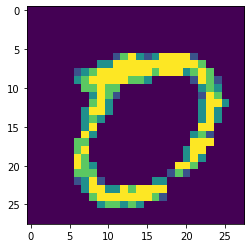

In [8]:
img_clean = input_tensor.cpu().numpy()
plt.imshow(img_clean[0,0])

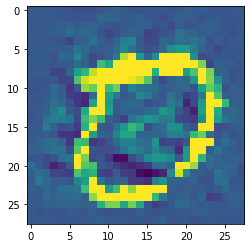

In [9]:
plt.imshow(adversarial_img[0,0])

In [41]:
pred_input = model(input_tensor)
pred_prob_input = F.softmax(pred_input, dim=1)
print('prediction of adversarial sample: {} with probability: {}'
      .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))

prediction of adversarial sample: 0 with probability: 0.882415235042572


In [40]:
pred_prob_adv = F.softmax(pred_adv, dim=1)
print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))


prediction of adversarial sample: 1 with probability: 0.13421384990215302


In [ ]:
target_onehot_ar = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
target_onehot = torch.from_numpy(target_onehot_ar)
target_onehot = target_onehot.cuda()

output_ar = np.array([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,-2.5990, -0.3694]])
output = torch.from_numpy(output_ar)
output = output.cuda()


In [ ]:
target_onehot

In [ ]:
output

In [ ]:
(target_onehot * output).sum(1)

In [ ]:
real = (target_onehot * output).sum(1)
real

In [ ]:
other = ((1. - target_onehot) * output - target_onehot * 10000.)
other

In [ ]:
other = (other).max(1)[0]
other

In [ ]:
other - real

In [ ]:
torch.clamp(other - real, min=0.)

In [ ]:
# target_onehot:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
# Batch:   0, search step: 0
# output:  tensor([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,
#          -2.5990, -0.3694]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
real:  tensor([-5.3372], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([-0.3694], device='cuda:0', grad_fn=<MaxBackward0>)


In [ ]:
real = (target * output).sum(1)
other = ((1. - target) * output - target * 10000.).max(1)[0]
        